# Мастерская - Соревнование на Kaggle. Предсказание продолжительности деятельности стартапа.
<a id='head'></a>

## Цель проекта
- Разработать модель машинного обучения для предсказания продолжительности деятельности стартапа.
- Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность стартапа).

In [1]:
!pip install phik -q
!pip install shap -q
!pip install category_encoders -q
!pip install catboost -q

In [2]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


## Библиотеки

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import pylab
import scipy.stats as stats
from scipy.stats import shapiro

from sklearn.model_selection import (train_test_split,
                                     cross_val_score,
                                     RandomizedSearchCV)
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix,
                             ConfusionMatrixDisplay,
                             precision_score,
                             f1_score,
                             roc_curve,
                             roc_auc_score)
from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler,
                                   LabelEncoder,
                                   FunctionTransformer
                                  )

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

from category_encoders import CountEncoder

from catboost import CatBoostClassifier

import warnings
import re
import phik
import shap
import random
from tqdm import tqdm

from datetime import datetime, timedelta

warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(12, 6)})
#sns.set_palette("viridis")

pd.set_option('display.max_columns', None)

RANDOM_STATE = 15
TEST_SIZE = 0.25
DATA_CUT = '2018-01-01'

In [4]:
startups_sample = pd.read_csv('kaggle_startups_sample_submit_28062024.csv')
startups_test = pd.read_csv('kaggle_startups_test_28062024.csv')
startups_train = pd.read_csv('kaggle_startups_train_28062024.csv')

In [5]:
startups_train.head(10)

name  \
0                  Lunchgate   
1                    EarLens   
2     Reviva Pharmaceuticals   
3       Sancilio and Company   
4        WireTough Cylinders   
5  Connected Sports Ventures   
6                  Attensity   
7              Mesh Networks   
8                 AngioScore   
9                 Vidatronic   

                                       category_list  funding_total_usd  \
0                    Online Reservations|Restaurants           828626.0   
1              Manufacturing|Medical|Medical Devices         42935019.0   
2                                      Biotechnology         35456381.0   
3                                        Health Care         22250000.0   
4                                      Manufacturing                NaN   
5                                             Mobile          4300000.0   
6  Analytics|Business Analytics|Social CRM|Social...         90000000.0   
7                                           Software          4300000.0   
8                                      Biotechnology         42000000.0   
9                                     Semiconductors          1250500.0   

      status country_code state_code       region             city  \
0  operating          CHE         25       Zurich           Zürich   
1  operating          USA         CA  SF Bay Area     Redwood City   
2  operating          USA         CA  SF Bay Area         San Jose   
3  operating          NaN        NaN          NaN              NaN   
4  operating          USA         VA   VA - Other          Bristol   
5  operating          USA         NJ       Newark        Princeton   
6  operating          USA         CA  SF Bay Area     Redwood City   
7  operating          USA         TX      Houston          Houston   
8  operating          USA         CA  SF Bay Area          Fremont   
9  operating          USA         TX       Austin  College Station   

   funding_rounds  founded_at first_funding_at last_funding_at closed_at  
0               2  2009-10-17       2011-05-01      2014-12-01       NaN  
1               4  2005-01-01       2010-05-04      2014-02-25       NaN  
2               3  2006-01-01       2012-08-20      2014-07-02       NaN  
3               3  2004-01-01       2011-09-01      2014-07-18       NaN  
4               1  2010-05-12       2012-02-01      2012-02-01       NaN  
5               1  2011-04-16       2012-11-12      2012-11-12       NaN  
6               1  2000-01-01       2014-05-14      2014-05-14       NaN  
7               1  2005-01-01       2014-11-09      2014-11-09       NaN  
8               2  2003-01-01       2007-10-09      2011-04-20       NaN  
9               2  2010-01-01       2011-08-23      2013-03-21       NaN

## Предобработка данных

### startup_train

In [6]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


Проверим на дубликаты название компаний

In [7]:
startups_train['name'].duplicated().sum()

np.int64(0)

Переведем признаки с датами в соответсвтующи формат

In [8]:
cols_to_datetime = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
for dt in cols_to_datetime:
  startups_train[dt] = pd.to_datetime(startups_train[dt])

In [9]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52515 non-null  object        
 1   category_list      50051 non-null  object        
 2   funding_total_usd  42447 non-null  float64       
 3   status             52516 non-null  object        
 4   country_code       47014 non-null  object        
 5   state_code         45753 non-null  object        
 6   region             46157 non-null  object        
 7   city               46157 non-null  object        
 8   funding_rounds     52516 non-null  int64         
 9   founded_at         52516 non-null  datetime64[ns]
 10  first_funding_at   52516 non-null  datetime64[ns]
 11  last_funding_at    52516 non-null  datetime64[ns]
 12  closed_at          4917 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory 

In [10]:
startups_train[startups_train['name'].isnull()]

name category_list  funding_total_usd  status country_code state_code  \
3291  NaN      Startups            25000.0  closed          USA         OR   

                region      city  funding_rounds founded_at first_funding_at  \
3291  Portland, Oregon  Portland               1 2011-10-01       2012-03-01   

     last_funding_at  closed_at  
3291      2012-03-01 2013-06-03

Необычная категория Startups

In [11]:
startups_train[startups_train['category_list'] == 'Startups']

name category_list  funding_total_usd     status  \
675               Coolr      Startups          1500000.0  operating   
3291                NaN      Startups            25000.0     closed   
5043           The Mill      Startups                NaN  operating   
5066            Lexicum      Startups            41347.0  operating   
5104              Oddup      Startups          1100000.0  operating   
6880              Vgulp      Startups            70000.0  operating   
9340        5M Ventures      Startups                NaN  operating   
14510            RedKix      Startups                NaN  operating   
15740         Snowledge      Startups            75000.0  operating   
19377        SteppinOut      Startups                NaN  operating   
22711          FidusNet      Startups          1400000.0  operating   
26205              UHOO      Startups                NaN  operating   
26224   Lighthouse Labs      Startups            50000.0  operating   
26271       StartupCali      Startups            40000.0  operating   
26759           Avatech      Startups          1400000.0  operating   
29629  Clippership Intl      Startups            50000.0  operating   
29688      Rancher Labs      Startups         10000000.0  operating   
31219       Smart Orbis      Startups           100000.0     closed   
31485         Moneypool      Startups                NaN  operating   
34437           Bitsbox      Startups           420000.0  operating   
36343        Shareapass      Startups             8868.0  operating   
37765        Propel ICT      Startups          2900000.0  operating   
38478           Temploy      Startups                NaN  operating   
39267        Clone Zone      Startups          1800000.0  operating   
39733          Cococure      Startups            70000.0  operating   
41338           Bloomon      Startups          3935960.0  operating   
44466            CPHFTW      Startups           150000.0  operating   
45315             Hobby      Startups           919997.0  operating   
45450            Bizdom      Startups           125000.0  operating   
46368      Kenesto Corp      Startups          4500000.0  operating   
48630        Triplebyte      Startups          3000000.0  operating   
49004        Freshworld      Startups                NaN  operating   
51160      YEDInstitute      Startups           377200.0  operating   

      country_code state_code            region           city  \
675            USA         WA           Seattle        Seattle   
3291           USA         OR  Portland, Oregon       Portland   
5043           USA         NV         Las Vegas      Las Vegas   
5066           GBR         H9            London         London   
5104           NaN        NaN               NaN            NaN   
6880           IND         19         Bangalore      Bangalore   
9340           FRA         A8             Paris          Paris   
14510          NaN        NaN               NaN            NaN   
15740          NaN        NaN               NaN            NaN   
19377          IND         19         Bangalore      Bangalore   
22711          USA         NY     New York City      Hawthorne   
26205          HKG        NaN         Hong Kong      Hong Kong   
26224          USA         VA          Richmond       Richmond   
26271          COL         29       COL - Other           Cali   
26759          IRN         26       IRN - Other         Tehran   
29629          NaN        NaN               NaN            NaN   
29688          USA         CA       SF Bay Area      Cupertino   
31219          NaN        NaN               NaN            NaN   
31485          NaN        NaN               NaN            NaN   
34437          USA         CO            Denver        Boulder   
36343          CAN         QC       Quebec City         Quebec   
37765          CAN         NB           Moncton        Moncton   
38478          SGP        NaN         Singapore      Singapore   
39267          USA  

In [12]:
startups_train[startups_train['category_list'] == 'Startups'].count()

name                 32
category_list        33
funding_total_usd    25
status               33
country_code         26
state_code           24
region               26
city                 26
funding_rounds       33
founded_at           33
first_funding_at     33
last_funding_at      33
closed_at             2
dtype: int64

Таких строк всего 33. Считаю, что их можно удалить, так как они не несут информации в какой категории ведут деятельность.


In [13]:
startups_train.drop(startups_train[startups_train['category_list'] == 'Startups'].index, inplace=True)

In [14]:
startups_train['category_list'].isnull().sum()

np.int64(2465)

In [15]:
startups_train['category_list'].isnull().sum() / startups_train.shape[0] * 100

np.float64(4.69675895051731)

In [16]:
startups_train['category_list'].fillna('unknown', inplace=True)

In [17]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52483 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52483 non-null  object        
 1   category_list      52483 non-null  object        
 2   funding_total_usd  42422 non-null  float64       
 3   status             52483 non-null  object        
 4   country_code       46988 non-null  object        
 5   state_code         45729 non-null  object        
 6   region             46131 non-null  object        
 7   city               46131 non-null  object        
 8   funding_rounds     52483 non-null  int64         
 9   founded_at         52483 non-null  datetime64[ns]
 10  first_funding_at   52483 non-null  datetime64[ns]
 11  last_funding_at    52483 non-null  datetime64[ns]
 12  closed_at          4915 non-null   datetime64[ns]
dtypes: datetime64[ns](4), float64(1), int64(1), object(7)
memory usage

Вычислим среднее кол-во категорий

In [18]:
startups_train['count_categories'] = startups_train['category_list'].apply(lambda x: len(x.split('|')))

average_count = startups_train['count_categories'].mean()

print(f'Среднее количество подкатегорий: {average_count}')

Среднее количество подкатегорий: 2.35161861936246


In [19]:
def cat_split(df, column, n_splits):
  splited_cat = df[column].str.split('|', n=n_splits, expand=True)
  splited_cat.columns = [f'{column}_{i+1}' for i in range(splited_cat.shape[1])]
  return splited_cat

Так как среднее количество категорий 2.35, то отберем 3 субкатегории. Далее, когда будем анализировать значимость признаков отберем те, которые вносят вклад в работу модели.

In [20]:
splited_cat = cat_split(startups_train, 'category_list', 2)
startups_train = pd.concat([startups_train, splited_cat], axis=1)

In [21]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52483 entries, 0 to 52515
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               52483 non-null  object        
 1   category_list      52483 non-null  object        
 2   funding_total_usd  42422 non-null  float64       
 3   status             52483 non-null  object        
 4   country_code       46988 non-null  object        
 5   state_code         45729 non-null  object        
 6   region             46131 non-null  object        
 7   city               46131 non-null  object        
 8   funding_rounds     52483 non-null  int64         
 9   founded_at         52483 non-null  datetime64[ns]
 10  first_funding_at   52483 non-null  datetime64[ns]
 11  last_funding_at    52483 non-null  datetime64[ns]
 12  closed_at          4915 non-null   datetime64[ns]
 13  count_categories   52483 non-null  int64         
 14  category_li

In [22]:
startups_train.drop(columns='category_list', inplace=True)

In [23]:
startups_train.head()

name  funding_total_usd     status country_code  \
0               Lunchgate           828626.0  operating          CHE   
1                 EarLens         42935019.0  operating          USA   
2  Reviva Pharmaceuticals         35456381.0  operating          USA   
3    Sancilio and Company         22250000.0  operating          NaN   
4     WireTough Cylinders                NaN  operating          USA   

  state_code       region          city  funding_rounds founded_at  \
0         25       Zurich        Zürich               2 2009-10-17   
1         CA  SF Bay Area  Redwood City               4 2005-01-01   
2         CA  SF Bay Area      San Jose               3 2006-01-01   
3        NaN          NaN           NaN               3 2004-01-01   
4         VA   VA - Other       Bristol               1 2010-05-12   

  first_funding_at last_funding_at closed_at  count_categories  \
0       2011-05-01      2014-12-01       NaT                 2   
1       2010-05-04      2014-02-25       NaT                 3   
2       2012-08-20      2014-07-02       NaT                 1   
3       2011-09-01      2014-07-18       NaT                 1   
4       2012-02-01      2012-02-01       NaT                 1   

       category_list_1 category_list_2  category_list_3  
0  Online Reservations     Restaurants             None  
1        Manufacturing         Medical  Medical Devices  
2        Biotechnology            None             None  
3          Health Care            None             None  
4        Manufacturing            None             None

In [24]:
startups_train[startups_train['closed_at'].notnull()]

name  funding_total_usd  status country_code  \
12                Iberic Premium       1.072390e+05  closed          NaN   
16                      Salesjob                NaN  closed          NaN   
23                         Vputi       5.000000e+04  closed          RUS   
24                       Savasti                NaN  closed          NaN   
29       NewWorld Communications       1.500000e+08  closed          NaN   
...                          ...                ...     ...          ...   
52453                  CakeStyle       1.000000e+06  closed          USA   
52455              Capcom groupe       1.065315e+07  closed          NaN   
52456                Grooveshark       4.552414e+06  closed          USA   
52459  Cortex Business Solutions       4.826784e+06  closed          CAN   
52485                    UK Coal                NaN  closed          GBR   

      state_code       region         city  funding_rounds founded_at  \
12           NaN          NaN          NaN               1 2013-07-26   
16           NaN          NaN          NaN               1 2013-01-01   
23            91  RUS - Other  Krasnoyarsk               1 2012-04-26   
24           NaN          NaN          NaN               1 2015-01-01   
29           NaN          NaN          NaN               1 1999-05-04   
...          ...          ...          ...             ...        ...   
52453         IL      Chicago      Chicago               1 2011-08-01   
52455        NaN          NaN          NaN               1 2014-11-15   
52456         FL  Gainesville  Gainesville               3 2006-03-01   
52459         AB      Calgary      Calgary               3 1999-01-01   
52485         D5    Doncaster    Doncaster               1 2004-01-11   

      first_funding_at last_funding_at  closed_at  count_categories  \
12          2014-06-01      2014-06-01 2015-07-10                 1   
16          2013-10-22      2013-10-22 2015-08-11                 1   
23          2013-03-08      2013-03-08 2014-09-04                 1   
24          2015-01-01      2015-01-01 2016-11-03                 1   
29          2000-06-01      2000-06-01 2001-12-28                 1   
...                ...             ...        ...               ...   
52453       2012-08-13      2012-08-13 2014-05-20                 4   
52455       2015-09-29      2015-09-29 2017-04-24                 3   
52456       2007-01-01      2010-11-30 2012-08-03                 3   
52459       2009-05-26      2013-04-18 2014-05-04                 1   
52485       2005-08-26      2005-08-26 2007-03-05                 1   

           category_list_1         category_list_2     category_list_3  
12                 unknown                    None                None  
16                 unknown                    None                None  
23               Consumers                    None                None  
24                 unknown                    None                None  
29              Technology                    None                None  
...                    ...                     ...                 ...  
52453          Curated Web                 Fashion    Lifestyle|Retail  
52455         Construction  Optical Communications  Telecommunications  
52456         File Sharing            Monetization               Music  
52459  Enterprise Software                    None                None  
52485  Mining Technologies                    None                None  

[4915 rows x 16 columns]

In [25]:
len(startups_train[startups_train['closed_at'].notnull()]) / startups_train.shape[0] * 100

9.364937217765751

В тренировочных данных 9% закрытых компаний.

В данных остались пропуски. Заполним их в пайплайне.

Для будущего анализа и группировке выделю год из дат.

In [26]:
year_to_extract_cols = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']

for y in year_to_extract_cols:
    startups_train['year_' + y] = startups_train[y].dt.year

Добавим новый признак с кол-ом дней между первым и последним раундом инвестиций.

In [27]:
def days_count(df, column_from, column_to):
    df[column_from] = pd.to_datetime(df[column_from])
    df[column_to] = pd.to_datetime(df[column_to])

    df['days_between_1_2_round'] = (df[column_to] - df[column_from]).dt.days

    return df['days_between_1_2_round']

In [28]:
startups_train['days_between_1_2_round'] = days_count(startups_train, 'first_funding_at', 'last_funding_at')

In [29]:
startups_train.head()

name  funding_total_usd     status country_code  \
0               Lunchgate           828626.0  operating          CHE   
1                 EarLens         42935019.0  operating          USA   
2  Reviva Pharmaceuticals         35456381.0  operating          USA   
3    Sancilio and Company         22250000.0  operating          NaN   
4     WireTough Cylinders                NaN  operating          USA   

  state_code       region          city  funding_rounds founded_at  \
0         25       Zurich        Zürich               2 2009-10-17   
1         CA  SF Bay Area  Redwood City               4 2005-01-01   
2         CA  SF Bay Area      San Jose               3 2006-01-01   
3        NaN          NaN           NaN               3 2004-01-01   
4         VA   VA - Other       Bristol               1 2010-05-12   

  first_funding_at last_funding_at closed_at  count_categories  \
0       2011-05-01      2014-12-01       NaT                 2   
1       2010-05-04      2014-02-25       NaT                 3   
2       2012-08-20      2014-07-02       NaT                 1   
3       2011-09-01      2014-07-18       NaT                 1   
4       2012-02-01      2012-02-01       NaT                 1   

       category_list_1 category_list_2  category_list_3  year_founded_at  \
0  Online Reservations     Restaurants             None             2009   
1        Manufacturing         Medical  Medical Devices             2005   
2        Biotechnology            None             None             2006   
3          Health Care            None             None             2004   
4        Manufacturing            None             None             2010   

   year_first_funding_at  year_last_funding_at  year_closed_at  \
0                   2011                  2014             NaN   
1                   2010                  2014             NaN   
2                   2012                  2014             NaN   
3                   2011                  2014             NaN   
4                   2012                  2012             NaN   

   days_between_1_2_round  
0                    1310  
1                    1393  
2                     681  
3                    1051  
4                       0

### startup_test

In [30]:
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [31]:
startups_test['name'].duplicated().sum()

np.int64(0)

In [32]:
startups_test['category_list'].fillna('unknown', inplace=True)

In [33]:
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      13125 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB


In [34]:
startups_test['days_between_1_2_round'] =  days_count(startups_test, 'first_funding_at', 'last_funding_at')


In [35]:
startups_test.head()

name                   category_list  funding_total_usd  \
0              Crystalsol                Clean Technology          2819200.0   
1        JBI Fish & Wings                     Hospitality                NaN   
2                COINPLUS                         Finance           428257.0   
3  Imagine Communications  Software|Video|Video Streaming         34700000.0   
4                   DNA13                        Software          4530000.0   

  country_code state_code            region              city  funding_rounds  \
0          NIC         17               NaN               NaN               1   
1          USA         TN        TN - Other          Humboldt               1   
2          LUX          3  Esch-sur-alzette  Esch-sur-alzette               2   
3          USA         CA         San Diego         San Diego               4   
4          CAN         ON            Ottawa            Ottawa               1   

  first_funding_at last_funding_at  lifetime  days_between_1_2_round  
0       2009-07-01      2009-07-01      3501                       0  
1       2010-07-28      2010-07-28      2717                       0  
2       2014-05-15      2014-09-18      1295                     126  
3       2005-01-01      2010-04-20      4748                    1935  
4       2007-05-08      2007-05-08      6209                       0

In [36]:
startups_test['count_categories'] = startups_test['category_list'].apply(lambda x: len(x.split('|')))

average_count = startups_test['count_categories'].mean()

print(f'Среднее количество подкатегорий: {average_count}')

Среднее количество подкатегорий: 2.352457142857143


In [37]:
splited_cat = cat_split(startups_test, 'category_list', 2)
startups_test = pd.concat([startups_test, splited_cat], axis=1)

In [38]:
startups_test.drop(columns='category_list', inplace=True)

In [39]:
year_to_extract_cols = ['first_funding_at', 'last_funding_at']

for y in year_to_extract_cols:
    startups_test[y] = pd.to_datetime(startups_test[y])
    startups_test['year_' + y] = startups_test[y].dt.year

In [40]:
startups_test.head()

name  funding_total_usd country_code state_code  \
0              Crystalsol          2819200.0          NIC         17   
1        JBI Fish & Wings                NaN          USA         TN   
2                COINPLUS           428257.0          LUX          3   
3  Imagine Communications         34700000.0          USA         CA   
4                   DNA13          4530000.0          CAN         ON   

             region              city  funding_rounds first_funding_at  \
0               NaN               NaN               1       2009-07-01   
1        TN - Other          Humboldt               1       2010-07-28   
2  Esch-sur-alzette  Esch-sur-alzette               2       2014-05-15   
3         San Diego         San Diego               4       2005-01-01   
4            Ottawa            Ottawa               1       2007-05-08   

  last_funding_at  lifetime  days_between_1_2_round  count_categories  \
0      2009-07-01      3501                       0                 1   
1      2010-07-28      2717                       0                 1   
2      2014-09-18      1295                     126                 1   
3      2010-04-20      4748                    1935                 3   
4      2007-05-08      6209                       0                 1   

    category_list_1 category_list_2  category_list_3  year_first_funding_at  \
0  Clean Technology            None             None                   2009   
1       Hospitality            None             None                   2010   
2           Finance            None             None                   2014   
3          Software           Video  Video Streaming                   2005   
4          Software            None             None                   2007   

   year_last_funding_at  
0                  2009  
1                  2010  
2                  2014  
3                  2010  
4                  2007

В тестовых данных также присутствуют пропуски, которые будут заполняться в пайплайне.

## Исследовательский анализ

### startup_train

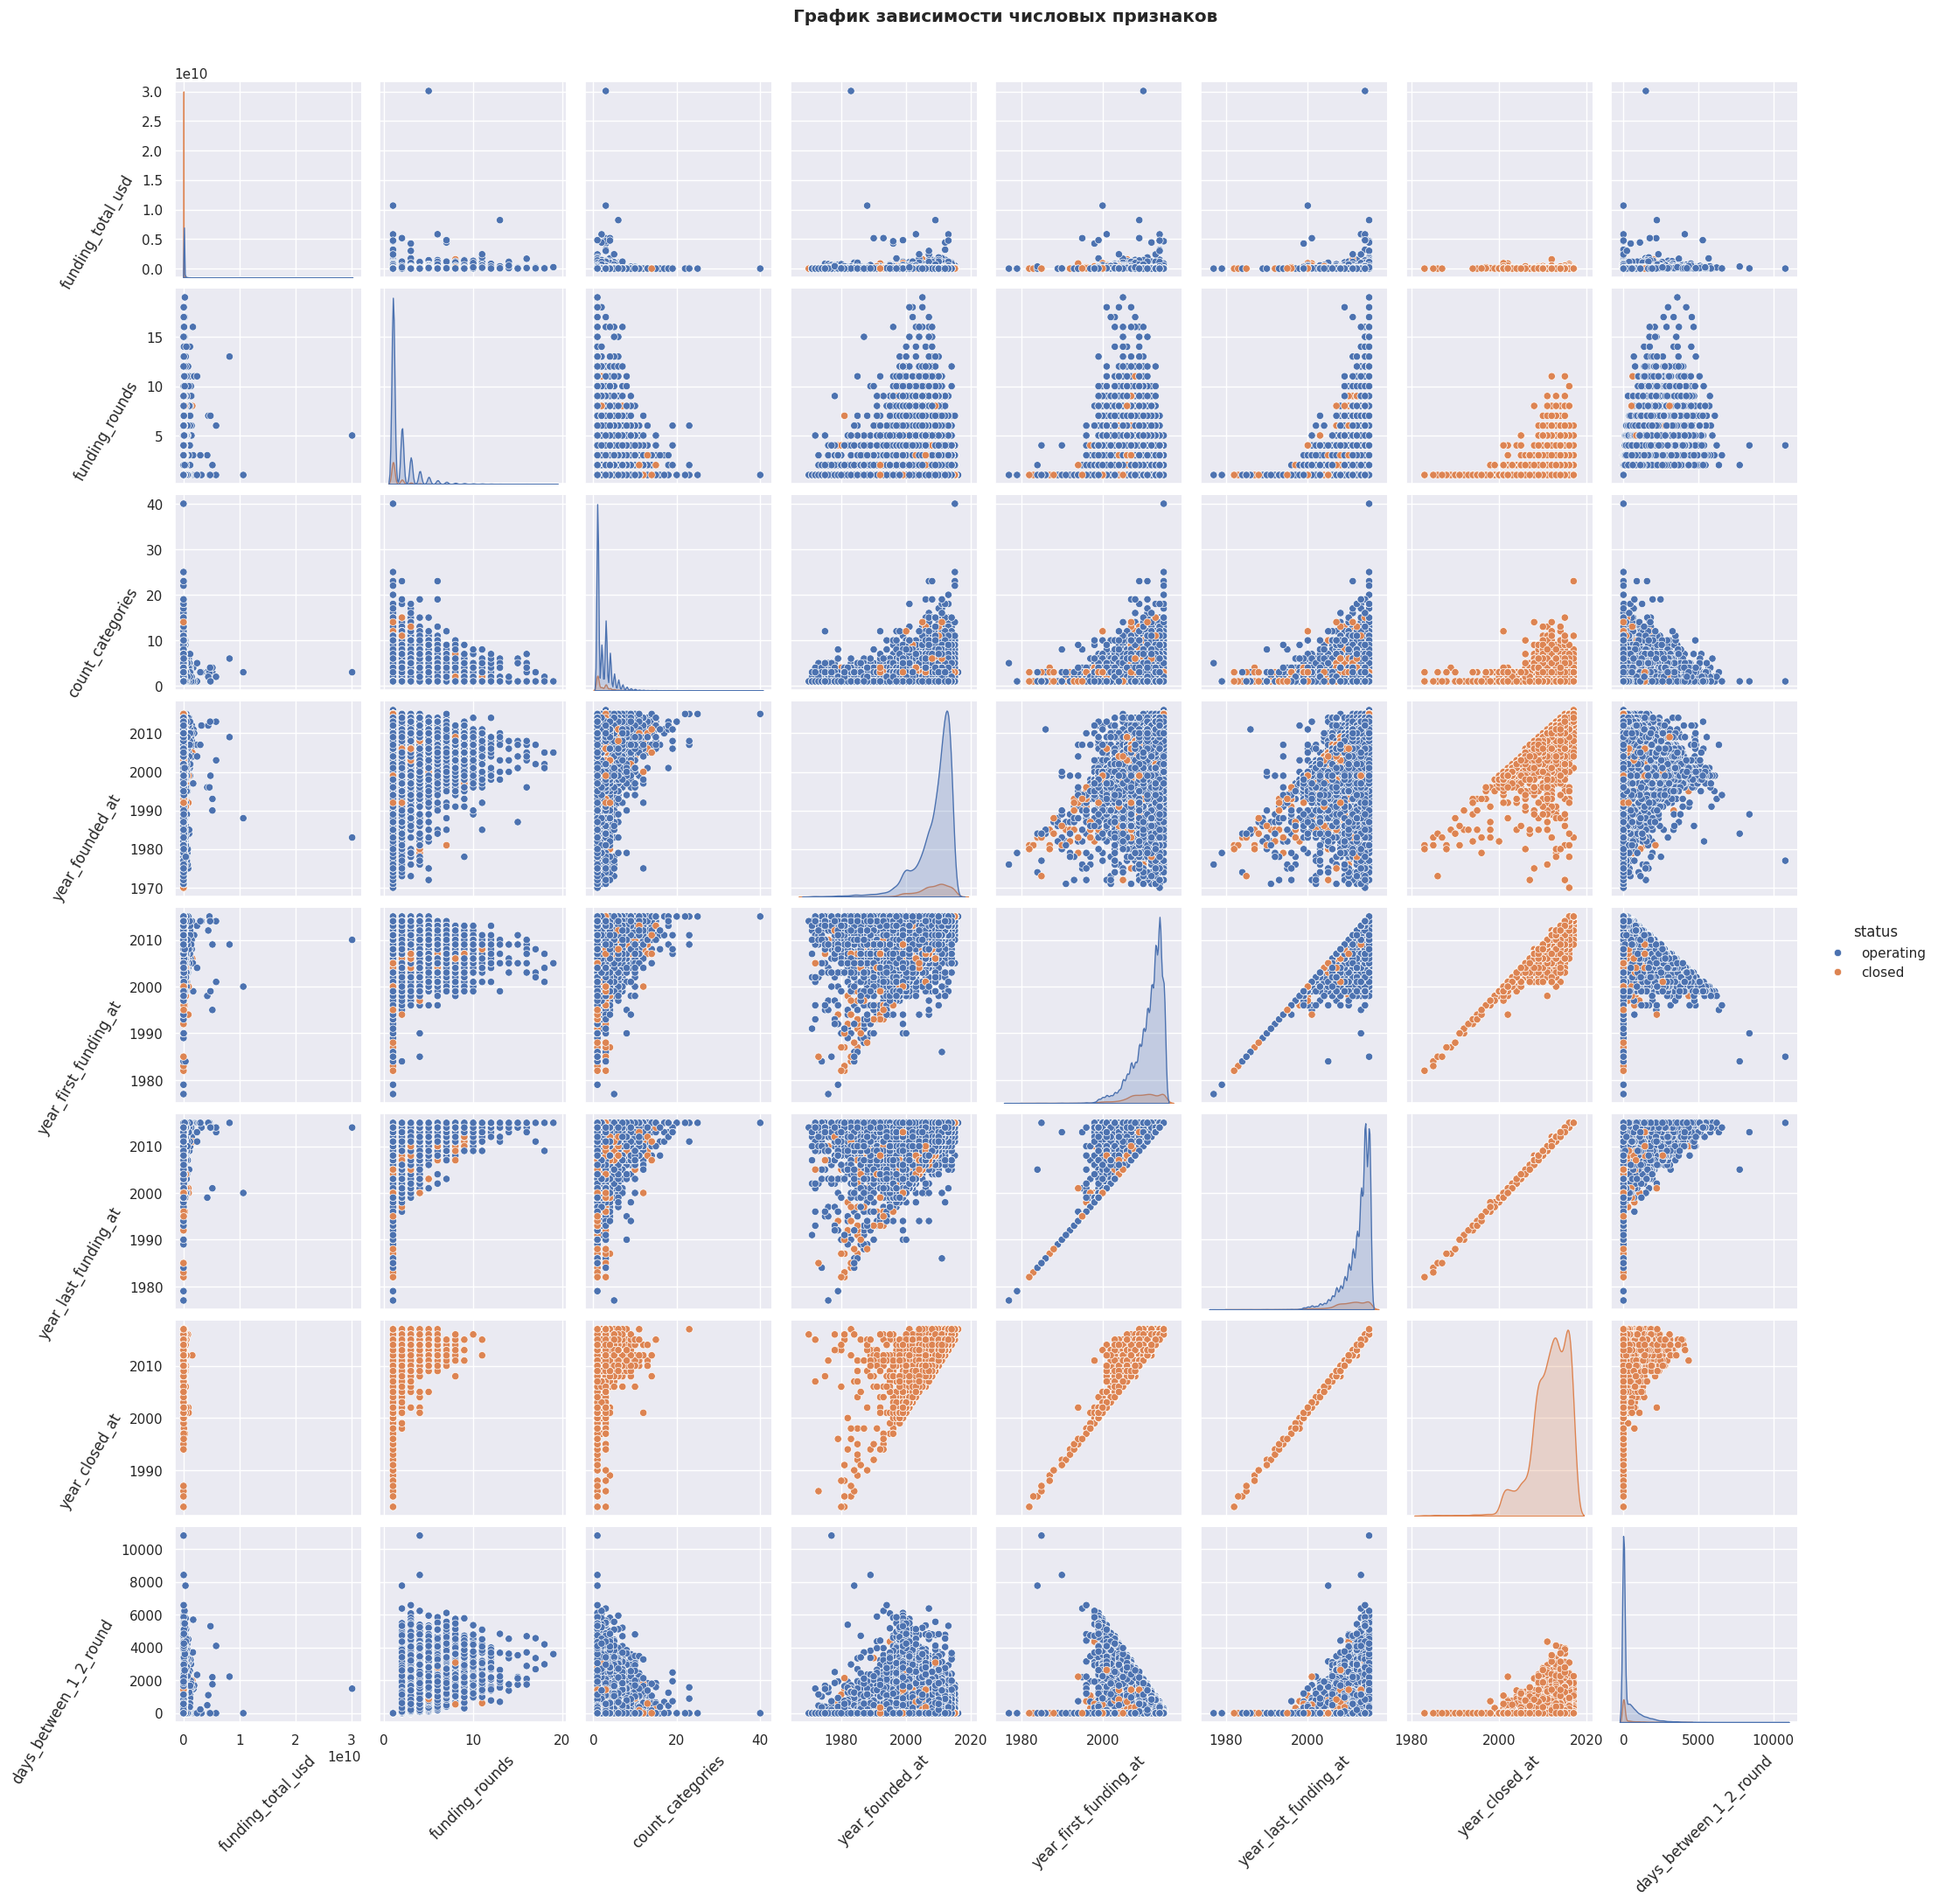

In [41]:
corr_plot = sns.pairplot(startups_train, diag_kind='kde', hue='status')
for axes in corr_plot.axes.flat:
    axes.set_ylabel(axes.get_ylabel(), rotation=60, horizontalalignment='right')
    axes.set_xlabel(axes.get_xlabel(), rotation=45)

plt.suptitle('График зависимости числовых признаков', y=1.02, weight='bold')
plt.show()

In [42]:
startups_train.country_code.value_counts().head(25)

country_code
USA    29690
GBR     2924
CAN     1537
IND     1273
CHN     1240
FRA      915
DEU      834
ISR      767
ESP      607
NLD      379
AUS      379
SWE      373
RUS      369
SGP      355
BRA      355
IRL      351
ITA      321
JPN      314
KOR      300
CHE      262
CHL      252
DNK      241
FIN      227
HKG      161
BEL      158
Name: count, dtype: int64

Переименуем страны с кол-во менее 300 в категорию other.

In [43]:
country_counts = startups_train['country_code'].value_counts()

countries_to_replace = country_counts[country_counts < 300].index

startups_train['country_code'] = startups_train['country_code'].replace(countries_to_replace, 'Other')

startups_train.country_code.value_counts().head(25)

country_code
USA      29690
Other     3705
GBR       2924
CAN       1537
IND       1273
CHN       1240
FRA        915
DEU        834
ISR        767
ESP        607
NLD        379
AUS        379
SWE        373
RUS        369
SGP        355
BRA        355
IRL        351
ITA        321
JPN        314
KOR        300
Name: count, dtype: int64

In [44]:
startups_train.city.value_counts().head(25)

city
San Francisco    2823
New York         2485
London           1513
Austin            609
Palo Alto         606
Los Angeles       604
Seattle           591
Chicago           546
Cambridge         542
Boston            508
Paris             484
San Diego         480
Beijing           464
Mountain View     463
Toronto           428
San Jose          359
Sunnyvale         358
Atlanta           346
Singapore         340
Bangalore         304
Santa Clara       299
Moscow            268
San Mateo         266
Dublin            263
Tel Aviv          259
Name: count, dtype: int64

Переименуем названия городов кол-во которых менее 250 в other

In [45]:
city_counts = startups_train.city.value_counts()

cities_to_replace = city_counts[city_counts < 250].index

startups_train['city'] = startups_train['city'].replace(cities_to_replace, 'Other')

startups_train.city.value_counts().head(25)

city
Other            28902
San Francisco     2823
New York          2485
London            1513
Austin             609
Palo Alto          606
Los Angeles        604
Seattle            591
Chicago            546
Cambridge          542
Boston             508
Paris              484
San Diego          480
Beijing            464
Mountain View      463
Toronto            428
San Jose           359
Sunnyvale          358
Atlanta            346
Singapore          340
Bangalore          304
Santa Clara        299
Moscow             268
San Mateo          266
Dublin             263
Name: count, dtype: int64

In [46]:
startups_train[startups_train['funding_total_usd'] > 3e10]

name  funding_total_usd     status country_code  \
39186  Verizon Communications       3.007950e+10  operating          USA   

      state_code         region      city  funding_rounds founded_at  \
39186         NY  New York City  New York               5 1983-10-07   

      first_funding_at last_funding_at closed_at  count_categories  \
39186       2010-01-26      2014-02-28       NaT                 3   

                     category_list_1         category_list_2 category_list_3  \
39186  Communications Infrastructure  Information Technology          Mobile   

       year_founded_at  year_first_funding_at  year_last_funding_at  \
39186             1983                   2010                  2014   

       year_closed_at  days_between_1_2_round  
39186             NaN                    1494

In [47]:
funding_ts = startups_train.groupby('year_first_funding_at')['funding_total_usd'].agg('mean')
funding_ts.head(10)

year_first_funding_at
1977    2.500000e+05
1979    1.000000e+06
1982    1.550000e+05
1983    9.400000e+04
1984    1.750500e+08
1985    2.897333e+06
1986             NaN
1987             NaN
1988             NaN
1989    1.500000e+04
Name: funding_total_usd, dtype: float64

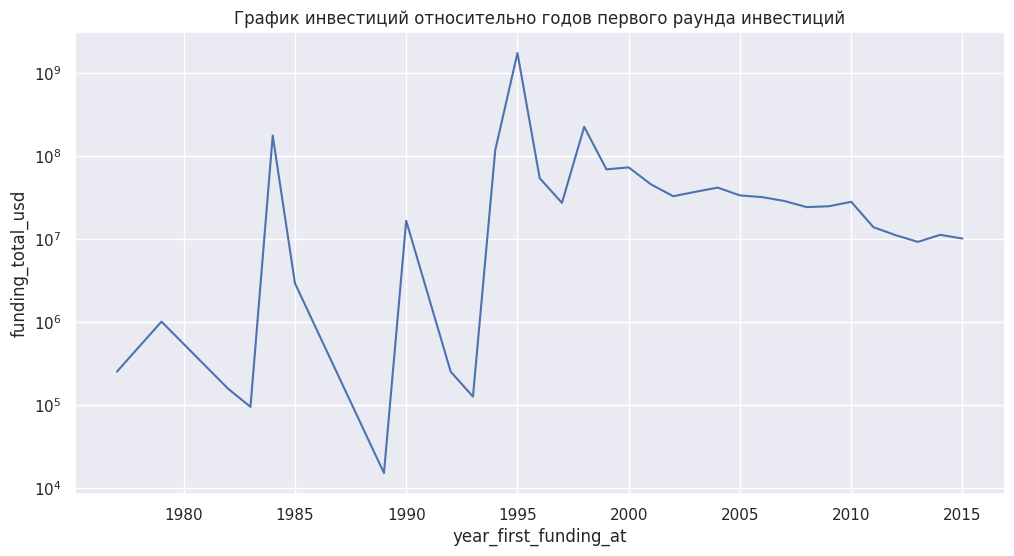

In [48]:
sns.lineplot(funding_ts)
plt.yscale('log')
plt.title('График инвестиций относительно годов первого раунда инвестиций')
plt.show()

На графике видно, что начиная с 2000 годов средняя сумма инвестиций плавно снижается. Также на графике можно увидеть экномические кризисы, до появления мягкой кредитно-денежной политики.

In [49]:
funding_ts = startups_train.groupby('year_first_funding_at')['funding_total_usd'].agg('mean').reset_index()
funding_ts['growth_rate'] = funding_ts['funding_total_usd'].pct_change()
funding_ts['marker'] = (funding_ts['growth_rate'] > 0).astype(int)

In [50]:
startups_train = pd.merge(startups_train, funding_ts[['year_first_funding_at', 'marker']],
                                 left_on='year_first_funding_at',
                                 right_on='year_first_funding_at',
                                 how='left')

In [51]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52483 entries, 0 to 52482
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    52483 non-null  object        
 1   funding_total_usd       42422 non-null  float64       
 2   status                  52483 non-null  object        
 3   country_code            46988 non-null  object        
 4   state_code              45729 non-null  object        
 5   region                  46131 non-null  object        
 6   city                    46131 non-null  object        
 7   funding_rounds          52483 non-null  int64         
 8   founded_at              52483 non-null  datetime64[ns]
 9   first_funding_at        52483 non-null  datetime64[ns]
 10  last_funding_at         52483 non-null  datetime64[ns]
 11  closed_at               4915 non-null   datetime64[ns]
 12  count_categories        52483 non-null  int64 

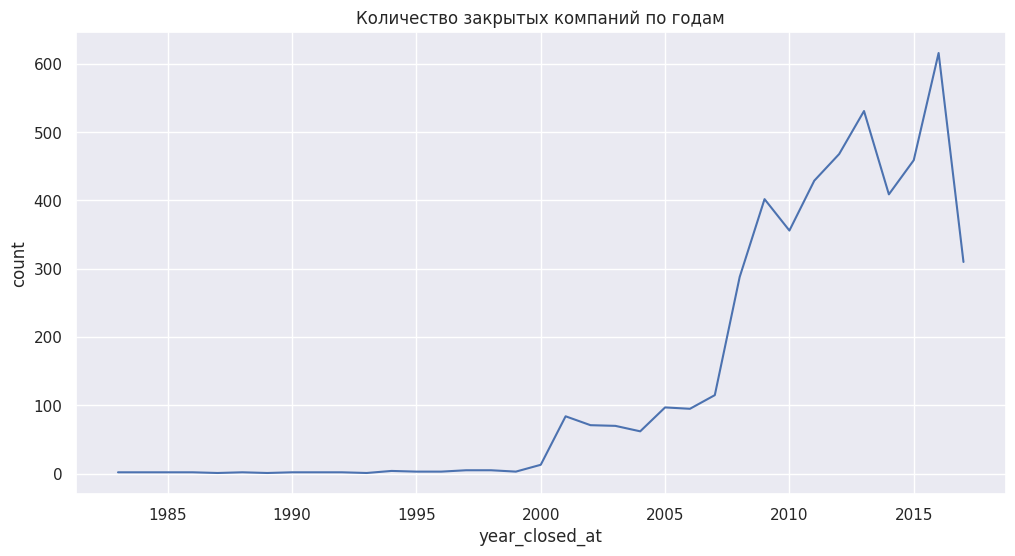

In [52]:
startup_close_count = startups_train[startups_train['year_closed_at'].notnull()]['year_closed_at'].value_counts().sort_index()
sns.lineplot(startup_close_count)
#plt.yscale('log')
plt.title('Количество закрытых компаний по годам')
plt.show()

In [53]:
def numeric_analysis(df, column, annot, xlim=None):
    # выводим таблицу со статистикой и считаем усы боксплота
    stat = df[column].describe()
    print(stat)
    up_whisker = stat['75%'] + 1.5 * (stat['75%'] - stat['25%'])
    low_whisker = stat['25%'] - 1.5 * (stat['75%'] - stat['25%'])

    print(f'\nВерхний ус: {round(up_whisker, 2)} \nНижний ус: {round(low_whisker, 2)} \
    \nМедианное значение: {df[column].median()}')

    # строим ящик с усами и гистограмму признака
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(df[column], orient="h", ax=ax_box)
    sns.histplot(data=df, x=column, ax=ax_hist, bins=100, kde=True)
    plt.axvline(df[column].mean(), color='r', linestyle='-', label=f'Среднее значение: {round(df[column].mean(), 2)}')
    plt.axvline(df[column].median(), color='g', linestyle='--', label=f'Медианное значение: {round(df[column].median(), 2)}')
    ax_box.set(xlabel='')
    ax_hist.legend(loc='best')
    ax_box.set_title(f'График распределения {annot}', weight='bold')

    if xlim is not None:
        ax_hist.set_xlim(xlim)

    plt.show()

In [54]:
num_cols = startups_train.select_dtypes(include='number').columns.tolist()
num_cols

['funding_total_usd',
 'funding_rounds',
 'count_categories',
 'year_founded_at',
 'year_first_funding_at',
 'year_last_funding_at',
 'year_closed_at',
 'days_between_1_2_round',
 'marker']

count    4.242200e+04
mean     1.825743e+07
std      1.871720e+08
min      1.000000e+00
25%      3.376250e+05
50%      2.000000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64

Верхний ус: 24493562.5 
Нижний ус: -14155937.5     
Медианное значение: 2000000.0


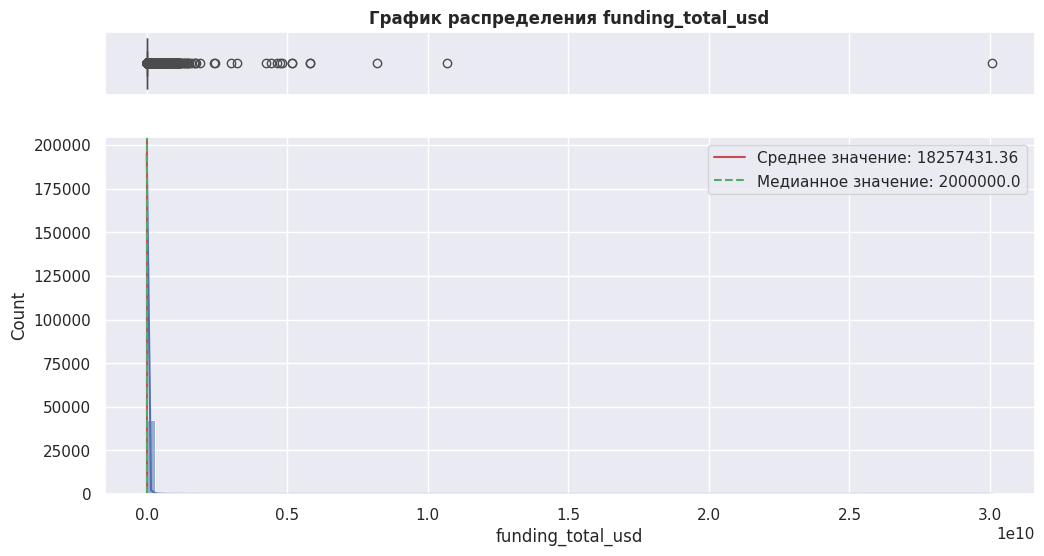

In [55]:
numeric_analysis(startups_train, 'funding_total_usd', 'funding_total_usd')

count    4.242200e+04
mean     1.825743e+07
std      1.871720e+08
min      1.000000e+00
25%      3.376250e+05
50%      2.000000e+06
75%      1.000000e+07
max      3.007950e+10
Name: funding_total_usd, dtype: float64

Верхний ус: 24493562.5 
Нижний ус: -14155937.5     
Медианное значение: 2000000.0


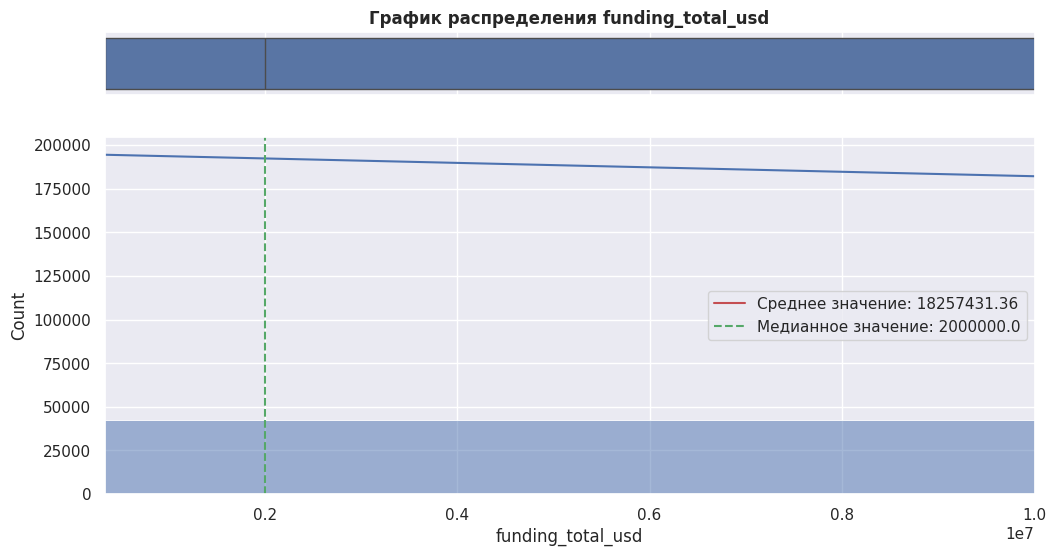

In [56]:
numeric_analysis(startups_train, 'funding_total_usd', 'funding_total_usd', xlim=(3.360275e+05, 1.000000e+07))

Проверим статистически имеются ли выбросы в признаке funding_total_usd

In [57]:
def z_score(ds, feature):
    data = ds[feature]
    z_scores = np.abs(stats.zscore(data))

    outliers = np.where(z_scores > 3)
    return outliers[0]

In [58]:
outliers = z_score(startups_train, 'funding_total_usd')
len(outliers)

0

Статистический метод показал, что признак `funding_total_usd` не имеет выбросов.

count    52483.000000
mean         1.741040
std          1.374845
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         19.000000
Name: funding_rounds, dtype: float64

Верхний ус: 3.5 
Нижний ус: -0.5     
Медианное значение: 1.0


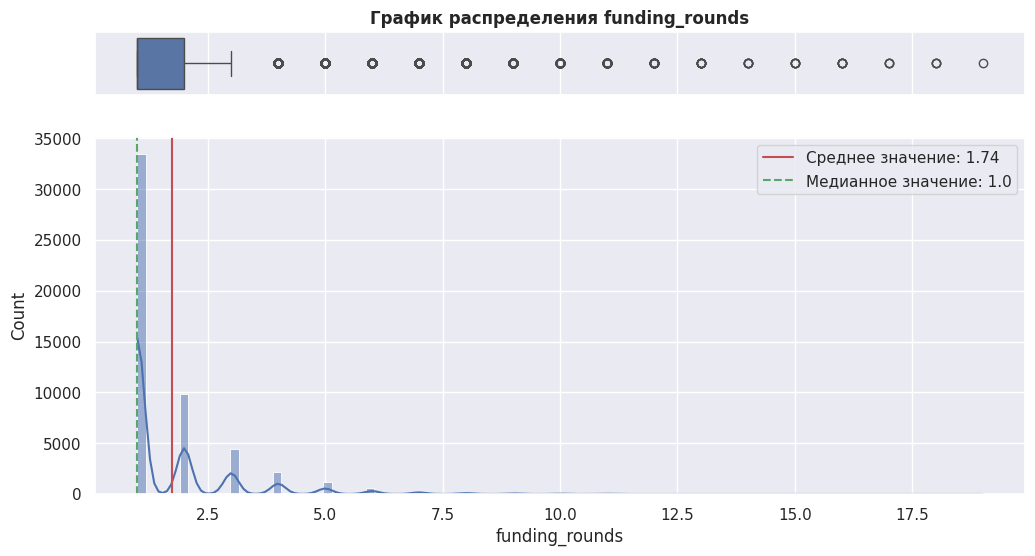

In [59]:
numeric_analysis(startups_train, 'funding_rounds', 'funding_rounds')

count    52483.000000
mean         2.351619
std          1.857183
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         40.000000
Name: count_categories, dtype: float64

Верхний ус: 6.0 
Нижний ус: -2.0     
Медианное значение: 2.0


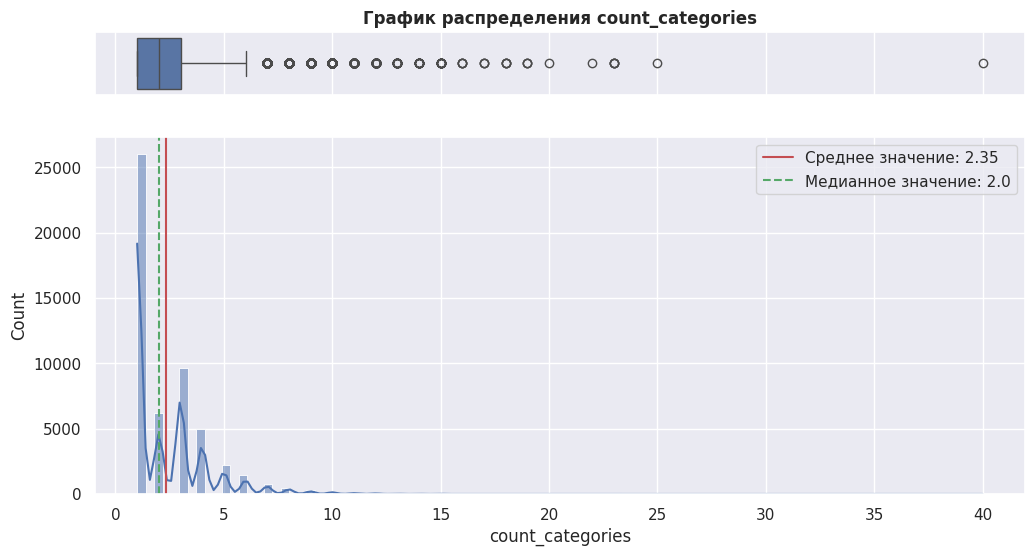

In [60]:
numeric_analysis(startups_train, 'count_categories', 'count_categories')

count    52483.000000
mean      2008.557438
std          5.757238
min       1970.000000
25%       2006.000000
50%       2010.000000
75%       2013.000000
max       2016.000000
Name: year_founded_at, dtype: float64

Верхний ус: 2023.5 
Нижний ус: 1995.5     
Медианное значение: 2010.0


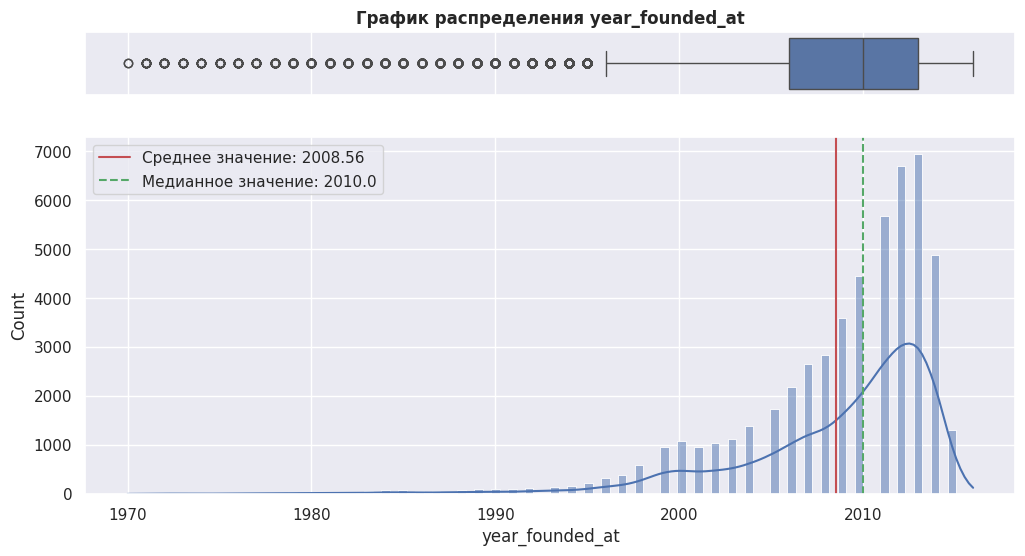

In [61]:
numeric_analysis(startups_train, 'year_founded_at', 'year_founded_at')

count    52483.000000
mean      2011.073967
std          3.613820
min       1977.000000
25%       2009.000000
50%       2012.000000
75%       2014.000000
max       2015.000000
Name: year_first_funding_at, dtype: float64

Верхний ус: 2021.5 
Нижний ус: 2001.5     
Медианное значение: 2012.0


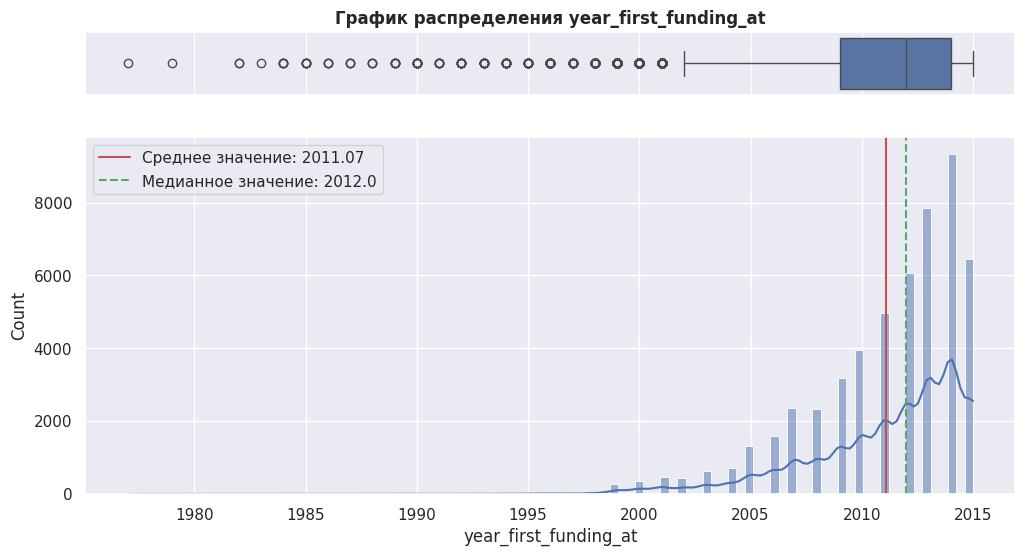

In [62]:
numeric_analysis(startups_train, 'year_first_funding_at', 'year_first_funding_at')

count    52483.000000
mean      2012.011166
std          3.337127
min       1977.000000
25%       2011.000000
50%       2013.000000
75%       2014.000000
max       2015.000000
Name: year_last_funding_at, dtype: float64

Верхний ус: 2018.5 
Нижний ус: 2006.5     
Медианное значение: 2013.0


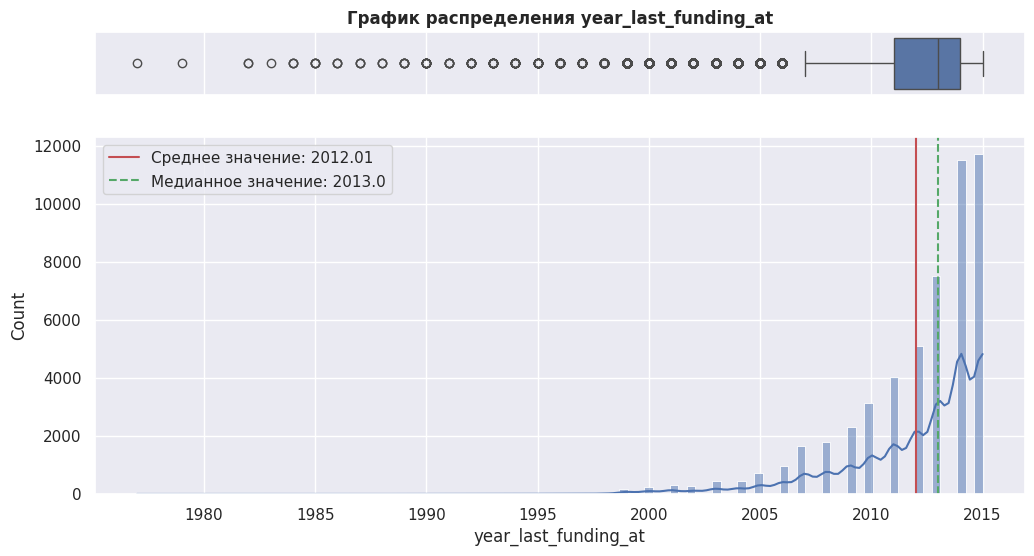

In [63]:
numeric_analysis(startups_train, 'year_last_funding_at', 'year_last_funding_at')

count    4915.000000
mean     2011.540387
std         4.234640
min      1983.000000
25%      2009.000000
50%      2012.000000
75%      2015.000000
max      2017.000000
Name: year_closed_at, dtype: float64

Верхний ус: 2024.0 
Нижний ус: 2000.0     
Медианное значение: 2012.0


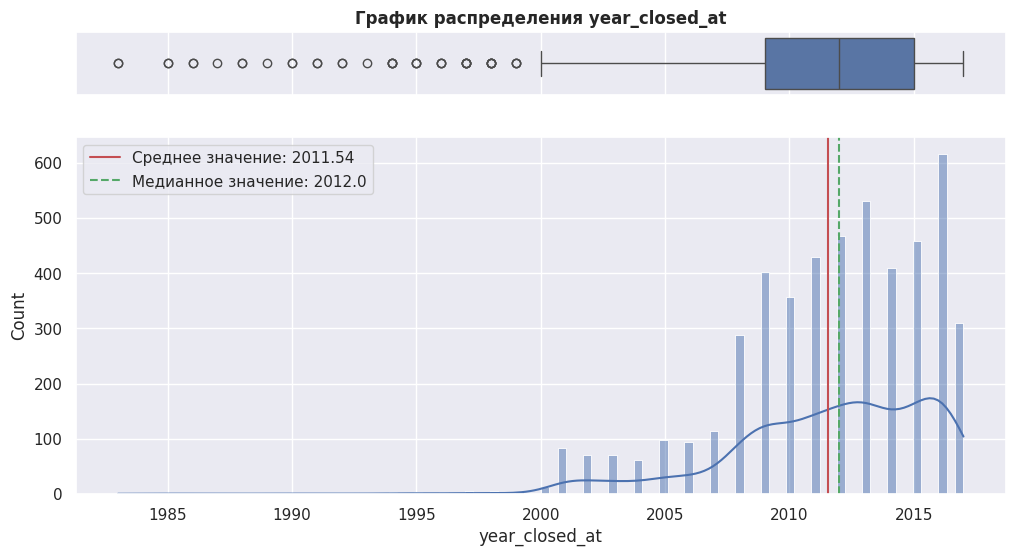

In [64]:
numeric_analysis(startups_train, 'year_closed_at', 'year_closed_at')

count    52483.000000
mean       346.644285
std        688.733499
min          0.000000
25%          0.000000
50%          0.000000
75%        427.000000
max      10807.000000
Name: days_between_1_2_round, dtype: float64

Верхний ус: 1067.5 
Нижний ус: -640.5     
Медианное значение: 0.0


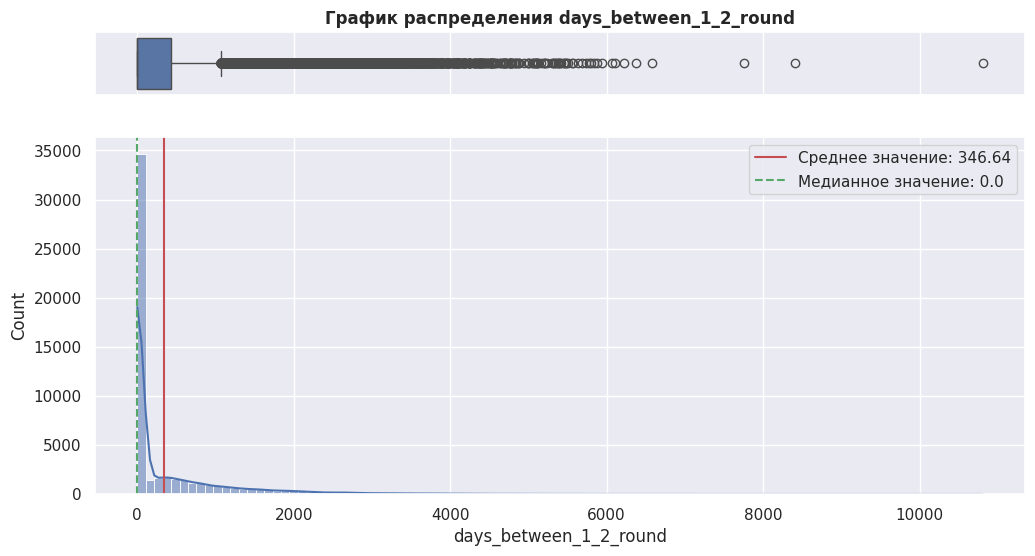

In [65]:
numeric_analysis(startups_train, 'days_between_1_2_round', 'days_between_1_2_round')

count    18806.000000
mean       967.400404
std        850.470691
min          1.000000
25%        366.000000
50%        713.000000
75%       1322.750000
max      10807.000000
Name: days_between_1_2_round, dtype: float64

Верхний ус: 2757.88 
Нижний ус: -1069.12     
Медианное значение: 713.0


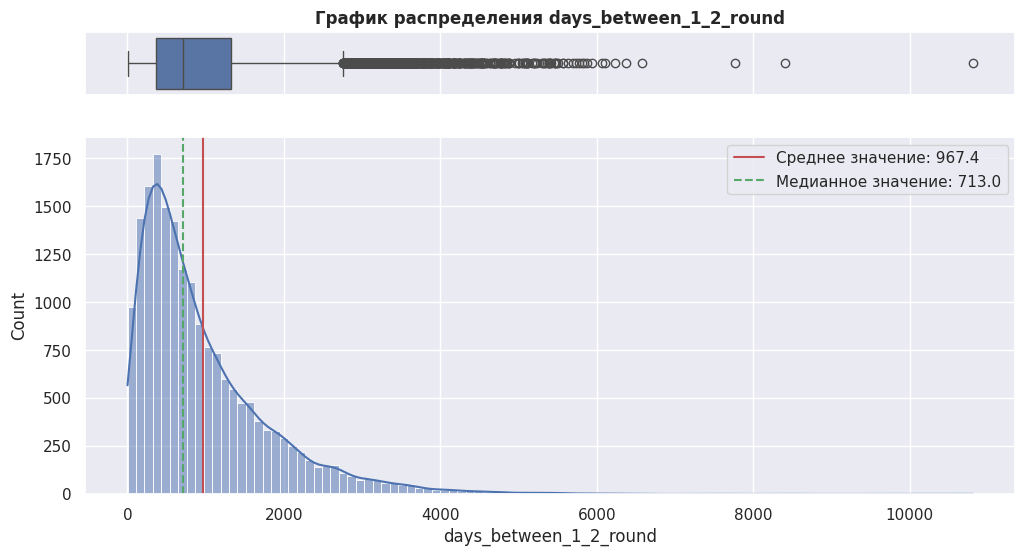

In [66]:
numeric_analysis(startups_train[startups_train['days_between_1_2_round'] != 0], 'days_between_1_2_round', 'days_between_1_2_round')

count    1135.000000
mean      786.601762
std       697.216636
min         1.000000
25%       280.000000
50%       572.000000
75%      1085.000000
max      4353.000000
Name: days_between_1_2_round, dtype: float64

Верхний ус: 2292.5 
Нижний ус: -927.5     
Медианное значение: 572.0


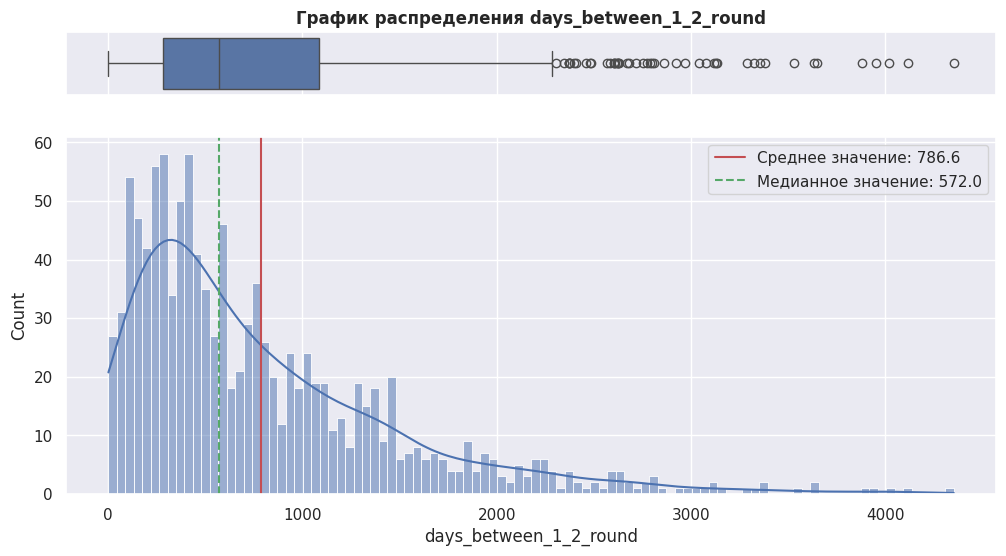

In [67]:
numeric_analysis(startups_train[(startups_train['status'] == 'closed') & (startups_train['days_between_1_2_round'] != 0)], 'days_between_1_2_round', 'days_between_1_2_round')

In [68]:
cat_cols = startups_train.select_dtypes(exclude='number').columns.tolist()
cat_cols

['name',
 'status',
 'country_code',
 'state_code',
 'region',
 'city',
 'founded_at',
 'first_funding_at',
 'last_funding_at',
 'closed_at',
 'category_list_1',
 'category_list_2',
 'category_list_3']

In [69]:
def cat_vis(cat):
  counts = startups_train[cat].value_counts()
  sns.barplot(x=counts.values,
                y=counts.index
               )
  plt.title(f'График распределения {cat}', weight='bold')
  plt.xlabel('Кол-во покупателей')
  plt.show()

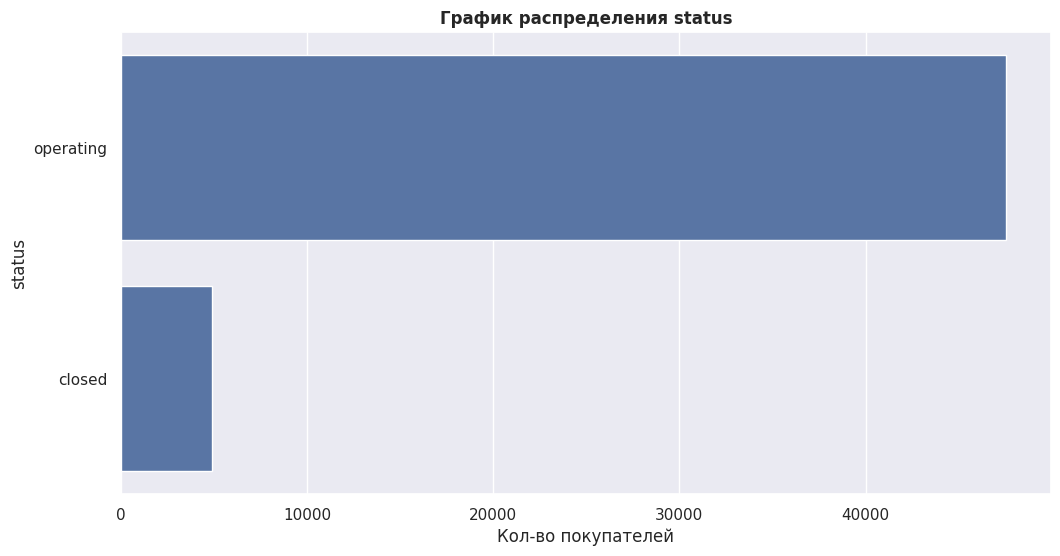

In [70]:
cat_vis('status')

Явный дисбаланс классов в целевом признаке.

### startup_test

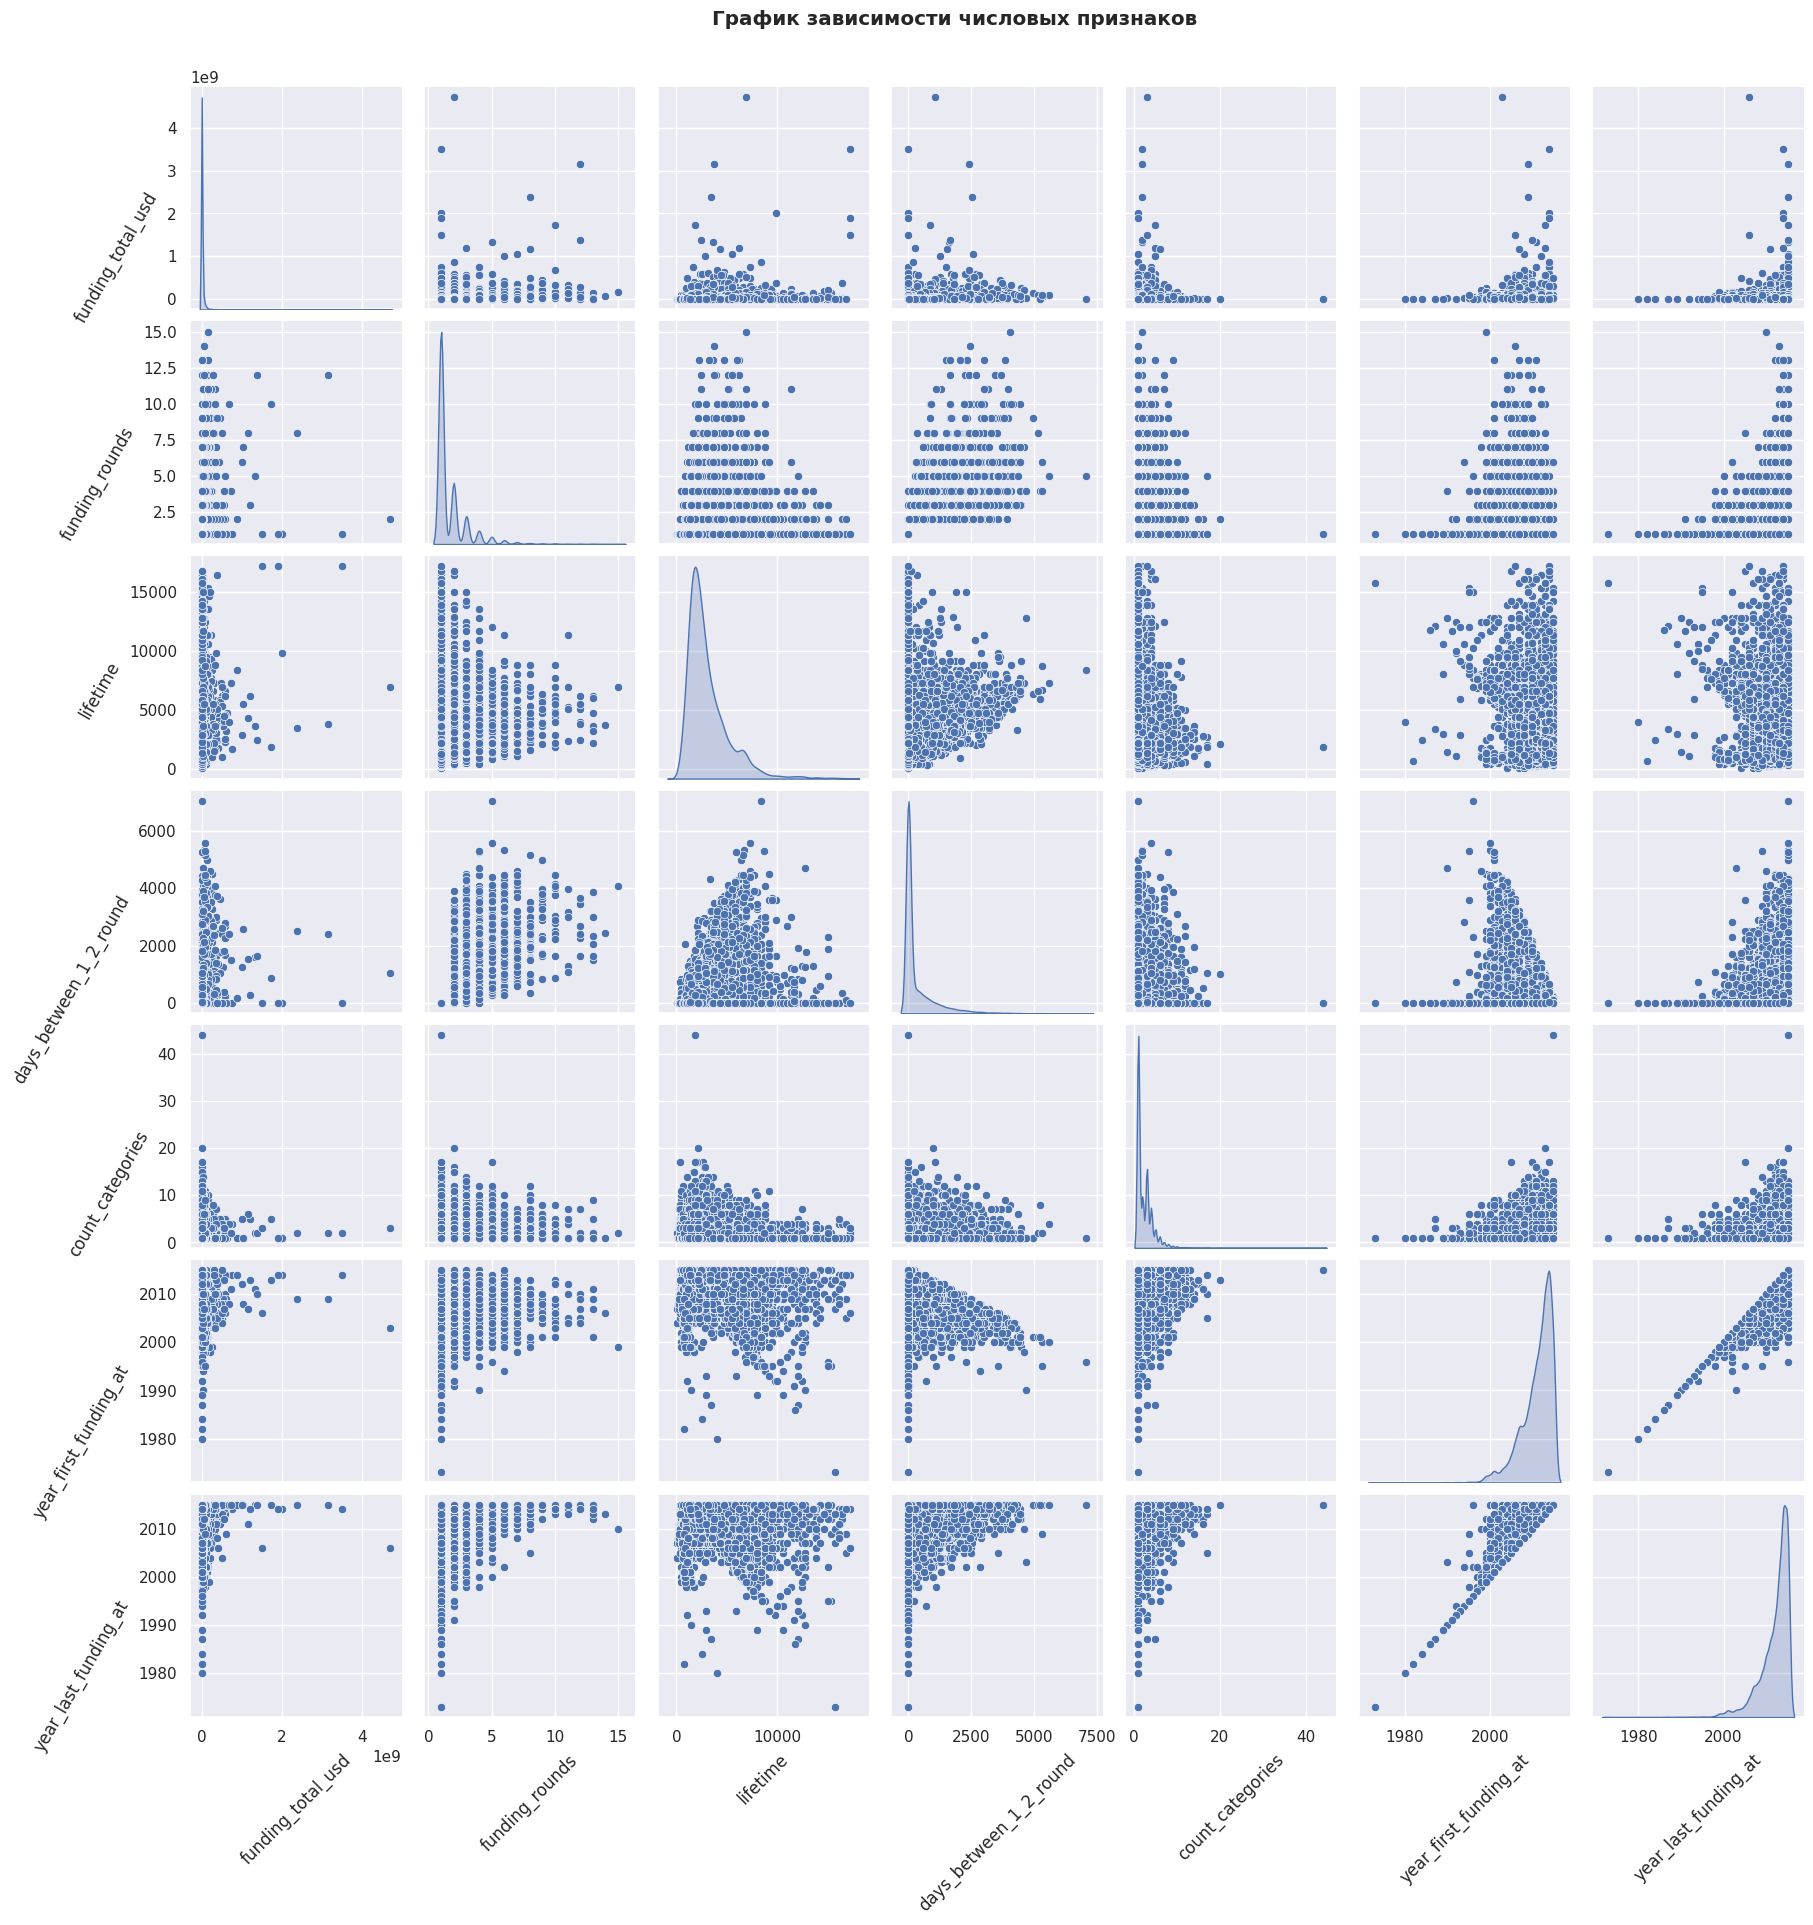

In [71]:
corr_plot = sns.pairplot(startups_test, diag_kind='kde')
for axes in corr_plot.axes.flat:
    axes.set_ylabel(axes.get_ylabel(), rotation=60, horizontalalignment='right')
    axes.set_xlabel(axes.get_xlabel(), rotation=45)

plt.suptitle('График зависимости числовых признаков', y=1.02, weight='bold')
plt.show()

In [72]:
funding_ts = startups_test.groupby('year_first_funding_at')['funding_total_usd'].agg('mean')
funding_ts.head(10)

year_first_funding_at
1973             NaN
1980    9.000000e+06
1982    1.650000e+05
1984    2.000000e+06
1986             NaN
1987    1.488000e+06
1989    1.000000e+06
1990    2.815000e+07
1991             NaN
1992    5.074333e+06
Name: funding_total_usd, dtype: float64

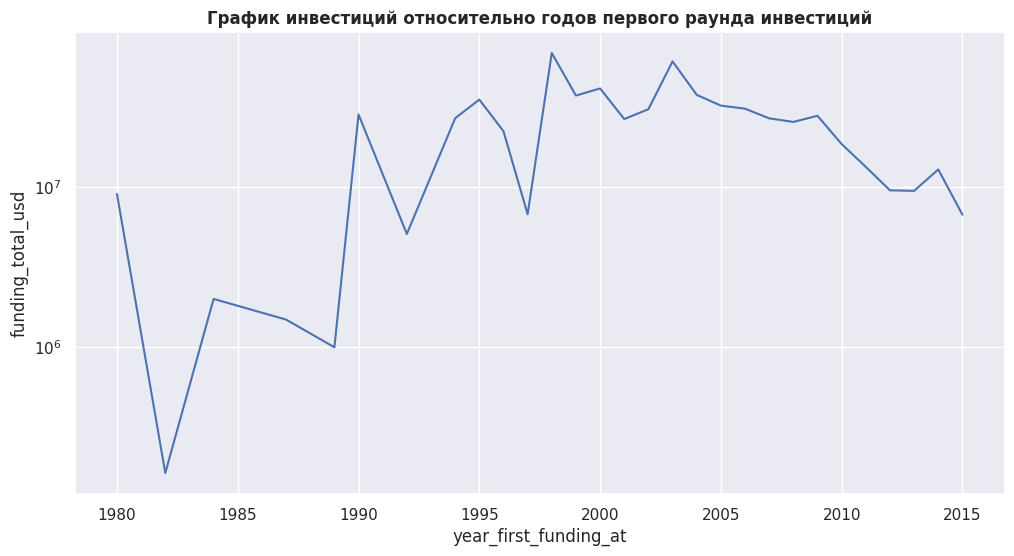

In [73]:
sns.lineplot(funding_ts)
plt.yscale('log')
plt.title('График инвестиций относительно годов первого раунда инвестиций', weight='bold')
plt.show()

In [74]:
funding_ts = startups_test.groupby('year_first_funding_at')['funding_total_usd'].agg('mean').reset_index()
funding_ts['growth_rate'] = funding_ts['funding_total_usd'].pct_change()
funding_ts['marker'] = (funding_ts['growth_rate'] > 0).astype(int)

In [75]:
startups_test = pd.merge(startups_test, funding_ts[['year_first_funding_at', 'marker']],
                                 left_on='year_first_funding_at',
                                 right_on='year_first_funding_at',
                                 how='left')

In [76]:
num_cols = startups_test.select_dtypes(include='number').columns.tolist()
num_cols

['funding_total_usd',
 'funding_rounds',
 'lifetime',
 'days_between_1_2_round',
 'count_categories',
 'year_first_funding_at',
 'year_last_funding_at',
 'marker']

count    1.054700e+04
mean     1.654910e+07
std      9.217283e+07
min      1.000000e+00
25%      3.200000e+05
50%      2.000000e+06
75%      1.000000e+07
max      4.715000e+09
Name: funding_total_usd, dtype: float64

Верхний ус: 24520000.0 
Нижний ус: -14200000.0     
Медианное значение: 2000000.0


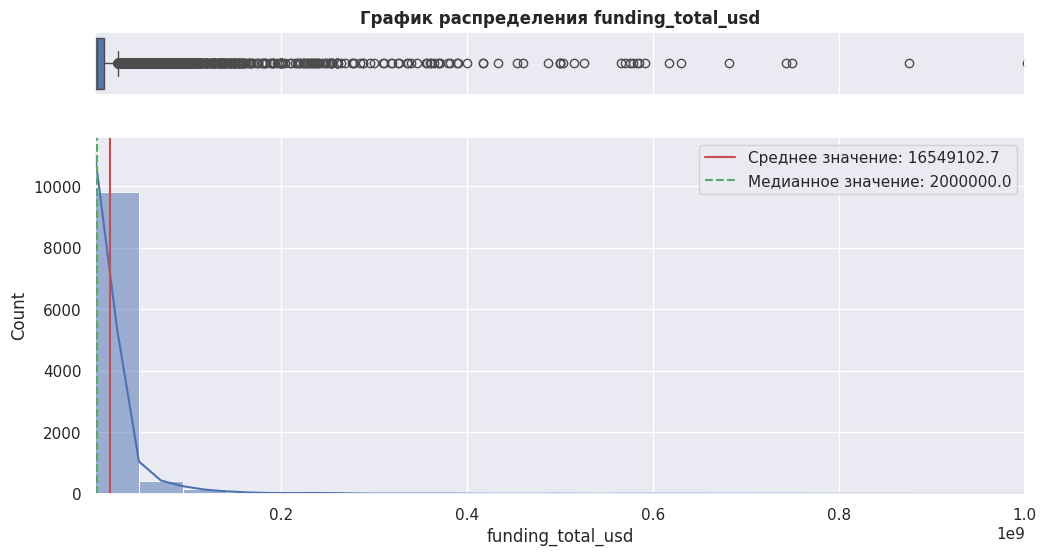

In [77]:
numeric_analysis(startups_test, 'funding_total_usd', 'funding_total_usd', xlim=(1, 1e9))

count    13125.000000
mean         1.714438
std          1.318800
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         15.000000
Name: funding_rounds, dtype: float64

Верхний ус: 3.5 
Нижний ус: -0.5     
Медианное значение: 1.0


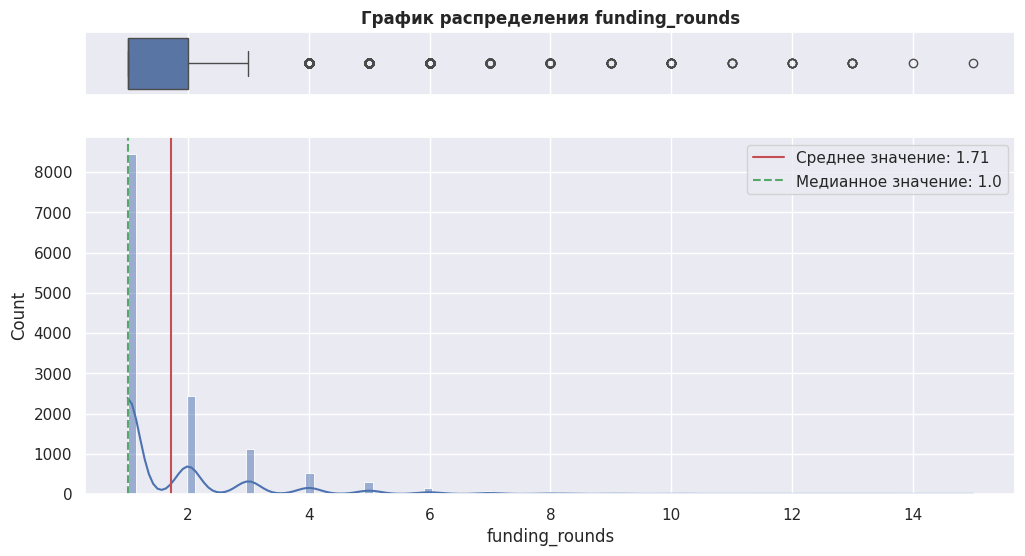

In [78]:
numeric_analysis(startups_test, 'funding_rounds', 'funding_rounds')

count    13125.000000
mean      3097.609524
std       2128.356554
min         52.000000
25%       1726.000000
50%       2526.000000
75%       3866.000000
max      17167.000000
Name: lifetime, dtype: float64

Верхний ус: 7076.0 
Нижний ус: -1484.0     
Медианное значение: 2526.0


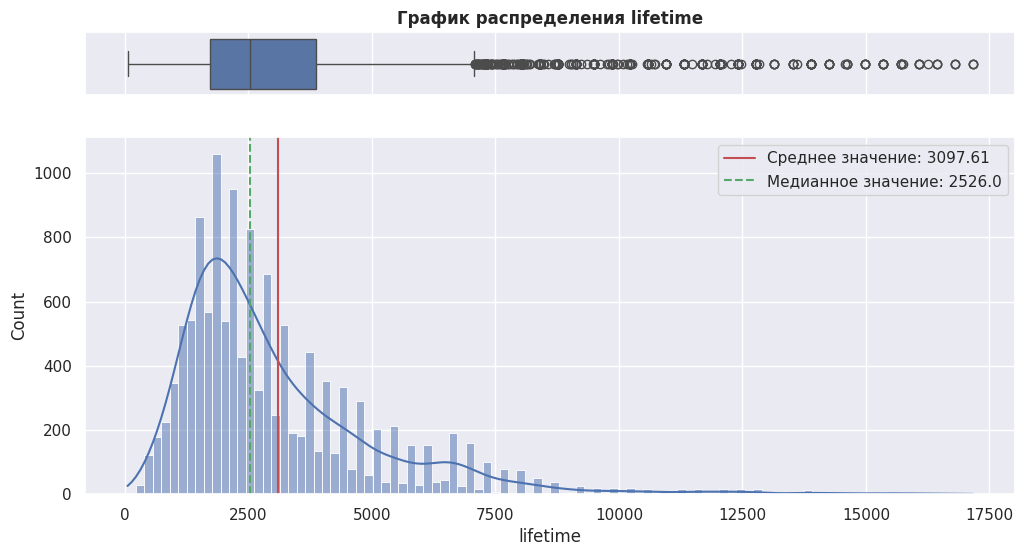

In [79]:
numeric_analysis(startups_test, 'lifetime', 'lifetime')

In [80]:
startups_test[startups_test['lifetime'] == 52]

name  funding_total_usd country_code state_code region city  \
789  Gemisimo                NaN          NaN        NaN    NaN  NaN   

     funding_rounds first_funding_at last_funding_at  lifetime  \
789               1       2007-01-01      2007-01-01        52   

     days_between_1_2_round  count_categories category_list_1  \
789                       0                 2         Jewelry   

      category_list_2 category_list_3  year_first_funding_at  \
789  Public Relations            None                   2007   

     year_last_funding_at  marker  
789                  2007       0

count    13125.000000
mean       328.339962
std        658.073065
min          0.000000
25%          0.000000
50%          0.000000
75%        391.000000
max       7038.000000
Name: days_between_1_2_round, dtype: float64

Верхний ус: 977.5 
Нижний ус: -586.5     
Медианное значение: 0.0


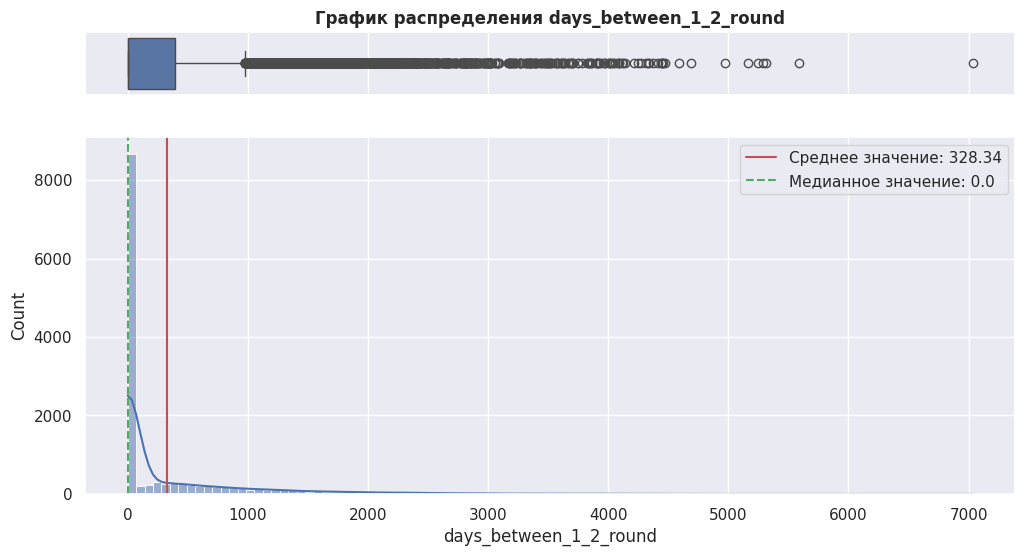

In [81]:
numeric_analysis(startups_test, 'days_between_1_2_round', 'days_between_1_2_round')

count    4625.000000
mean      931.775568
std       816.540553
min         1.000000
25%       350.000000
50%       690.000000
75%      1279.000000
max      7038.000000
Name: days_between_1_2_round, dtype: float64

Верхний ус: 2672.5 
Нижний ус: -1043.5     
Медианное значение: 690.0


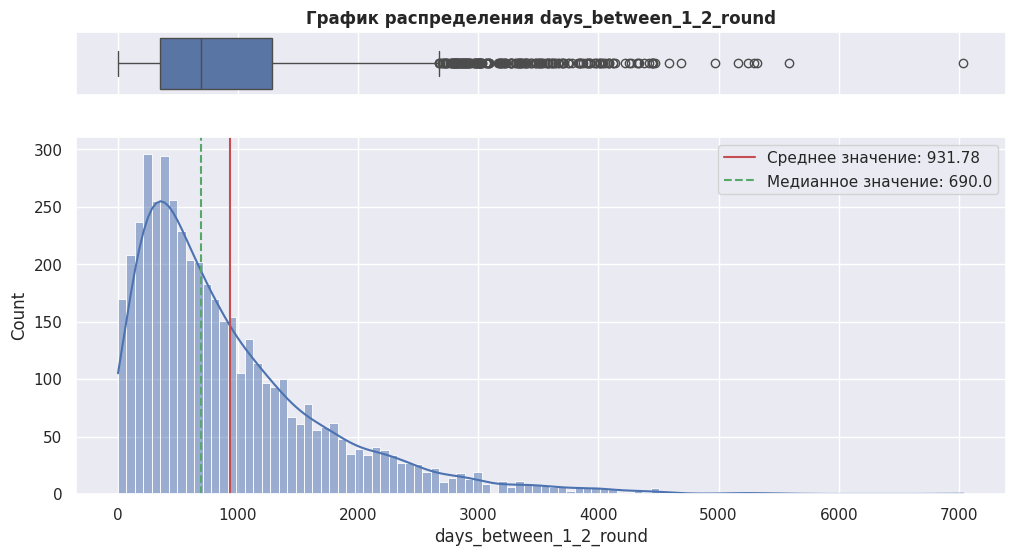

In [82]:
numeric_analysis(startups_test[startups_test['days_between_1_2_round'] != 0], 'days_between_1_2_round', 'days_between_1_2_round')

## Добавление признаков

In [83]:
startups_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    13125 non-null  object        
 1   funding_total_usd       10547 non-null  float64       
 2   country_code            11743 non-null  object        
 3   state_code              11430 non-null  object        
 4   region                  11536 non-null  object        
 5   city                    11538 non-null  object        
 6   funding_rounds          13125 non-null  int64         
 7   first_funding_at        13125 non-null  datetime64[ns]
 8   last_funding_at         13125 non-null  datetime64[ns]
 9   lifetime                13125 non-null  int64         
 10  days_between_1_2_round  13125 non-null  int64         
 11  count_categories        13125 non-null  int64         
 12  category_list_1         13125 non-null  object

In [84]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52483 entries, 0 to 52482
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    52483 non-null  object        
 1   funding_total_usd       42422 non-null  float64       
 2   status                  52483 non-null  object        
 3   country_code            46988 non-null  object        
 4   state_code              45729 non-null  object        
 5   region                  46131 non-null  object        
 6   city                    46131 non-null  object        
 7   funding_rounds          52483 non-null  int64         
 8   founded_at              52483 non-null  datetime64[ns]
 9   first_funding_at        52483 non-null  datetime64[ns]
 10  last_funding_at         52483 non-null  datetime64[ns]
 11  closed_at               4915 non-null   datetime64[ns]
 12  count_categories        52483 non-null  int64 

Создадим признак lifetime в startups_train

In [85]:
startups_train['lifetime'] = np.where(
    startups_train['closed_at'].isna(),
    (pd.to_datetime(DATA_CUT) - pd.to_datetime(startups_train['founded_at'])).dt.days,
    (pd.to_datetime(startups_train['closed_at']) - pd.to_datetime(startups_train['founded_at'])).dt.days
)

count    52483.000000
mean      3141.749805
std       2148.070902
min         19.000000
25%       1740.000000
50%       2557.000000
75%       4018.000000
max      17378.000000
Name: lifetime, dtype: float64

Верхний ус: 7435.0 
Нижний ус: -1677.0     
Медианное значение: 2557.0


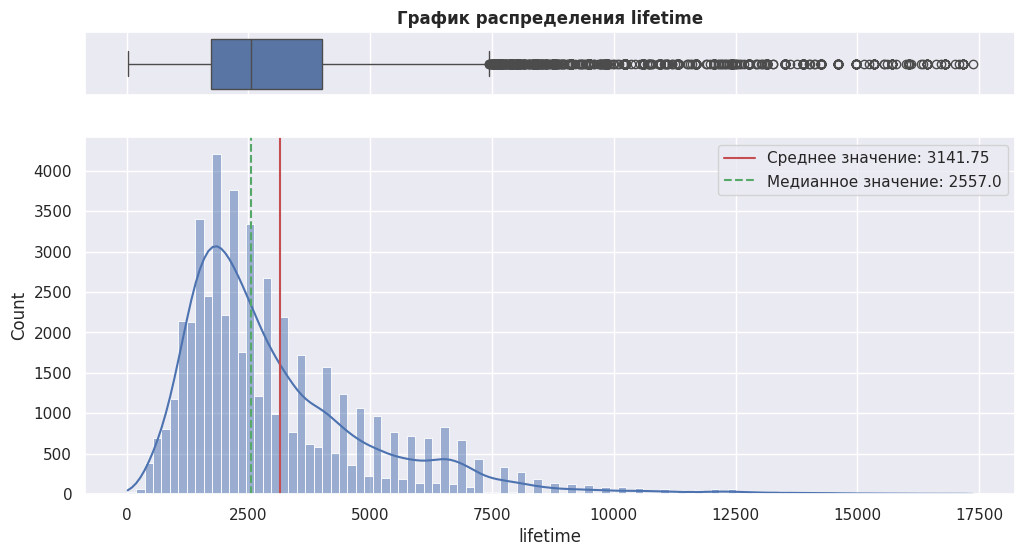

In [86]:
numeric_analysis(startups_train, 'lifetime', 'lifetime')

Проверим есть ли выборосы в признаке lifetime

In [87]:
outliers = z_score(startups_train, 'lifetime')
len(outliers)

928

In [88]:
len(outliers) / startups_train.shape[0] * 100

1.7681916049006348

Имеем 928 выбросов

Избавимся от выбросов, т.к. их кол-во составляет менее 2% от тренировочного датасета

In [89]:
startups_train = startups_train.drop(index=outliers).reset_index(drop=True)

count    51555.000000
mean      2979.172903
std       1771.291917
min         19.000000
25%       1730.000000
50%       2508.000000
75%       3832.000000
max       9584.000000
Name: lifetime, dtype: float64

Верхний ус: 6985.0 
Нижний ус: -1423.0     
Медианное значение: 2508.0


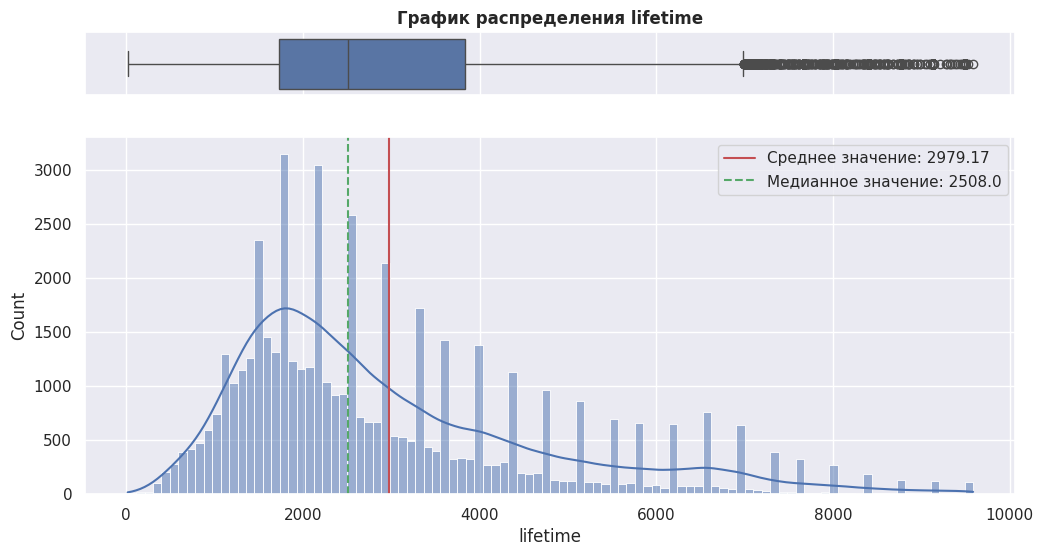

In [90]:
numeric_analysis(startups_train, 'lifetime', 'lifetime')

In [91]:
startups_train['log_funding_total_usd'] = np.log(startups_train['funding_total_usd'])

In [92]:
def diagnostic_plots(df, variable):

    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=pylab)

    plt.show()

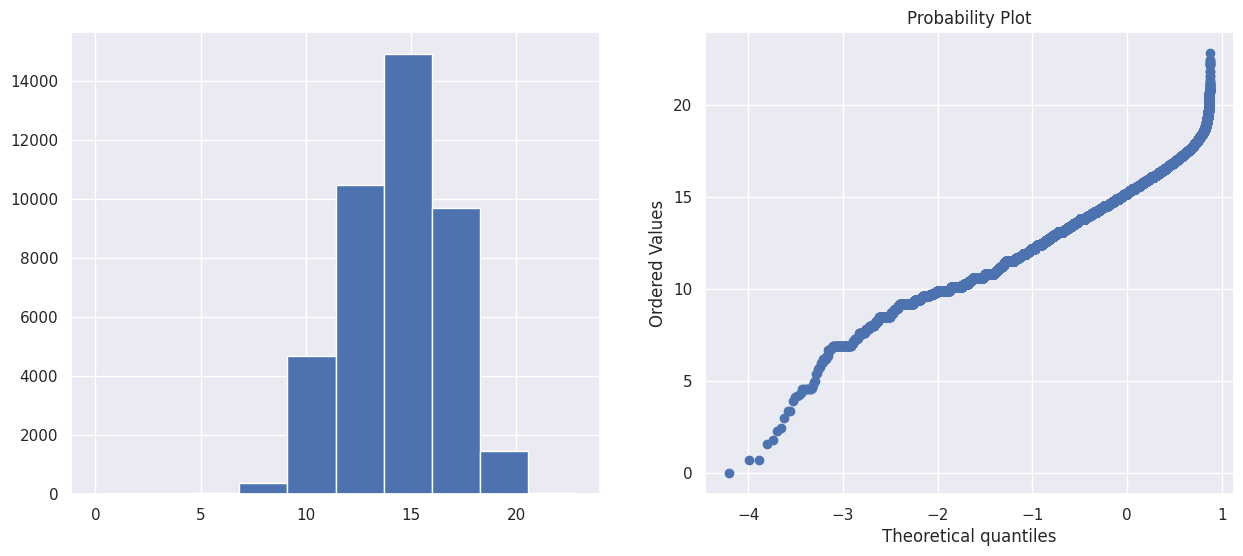

In [93]:
diagnostic_plots(startups_train, 'log_funding_total_usd')

In [94]:
startups_train.columns

Index(['name', 'funding_total_usd', 'status', 'country_code', 'state_code',
       'region', 'city', 'funding_rounds', 'founded_at', 'first_funding_at',
       'last_funding_at', 'closed_at', 'count_categories', 'category_list_1',
       'category_list_2', 'category_list_3', 'year_founded_at',
       'year_first_funding_at', 'year_last_funding_at', 'year_closed_at',
       'days_between_1_2_round', 'marker', 'lifetime',
       'log_funding_total_usd'],
      dtype='object')

In [95]:
startups_test['log_funding_total_usd'] = np.log(startups_test['funding_total_usd'])

In [96]:
startups_train['mean_fund_per_round'] = startups_train['funding_total_usd'] / startups_train['funding_rounds']

In [97]:
startups_test['mean_fund_per_round'] = startups_test['funding_total_usd'] / startups_test['funding_rounds']

In [98]:
days_since_investment = (2018 - startups_train['year_first_funding_at']) * 365
startups_train['days_from_1_round'] = startups_train['lifetime'] - days_since_investment

In [99]:
days_since_investment = (2018 - startups_test['year_first_funding_at']) * 365
startups_test['days_from_1_round'] = startups_test['lifetime'] - days_since_investment

In [100]:
days_since_last_investment = (2018 - startups_train['year_last_funding_at']) * 365
startups_train['days_from_last_round'] = startups_train['lifetime'] - days_since_last_investment

In [101]:
days_since_last_investment = (2018 - startups_test['year_last_funding_at']) * 365
startups_test['days_from_last_round'] = startups_test['lifetime'] - days_since_last_investment


In [102]:
startups_train['fund_per_day'] = startups_train['funding_total_usd'] / startups_train['lifetime']
startups_test['fund_per_day'] = startups_test['funding_total_usd'] / startups_test['lifetime']

## Корреляционный анализ

Кодирование категориальных данных и целевого признака для формирования матрицы корреляции

In [103]:
encoder = CountEncoder()

categorical_cols = startups_train.drop(columns='status').select_dtypes(include=['object']).columns

encoded_df = encoder.fit_transform(startups_train[categorical_cols])

l_encoder = LabelEncoder()

startups_train['status'] = l_encoder.fit_transform(startups_train['status'])

numeric_df = startups_train.select_dtypes(include=['number'])
final_df = pd.concat([numeric_df, encoded_df], axis=1)

correlation_matrix = final_df.corr()

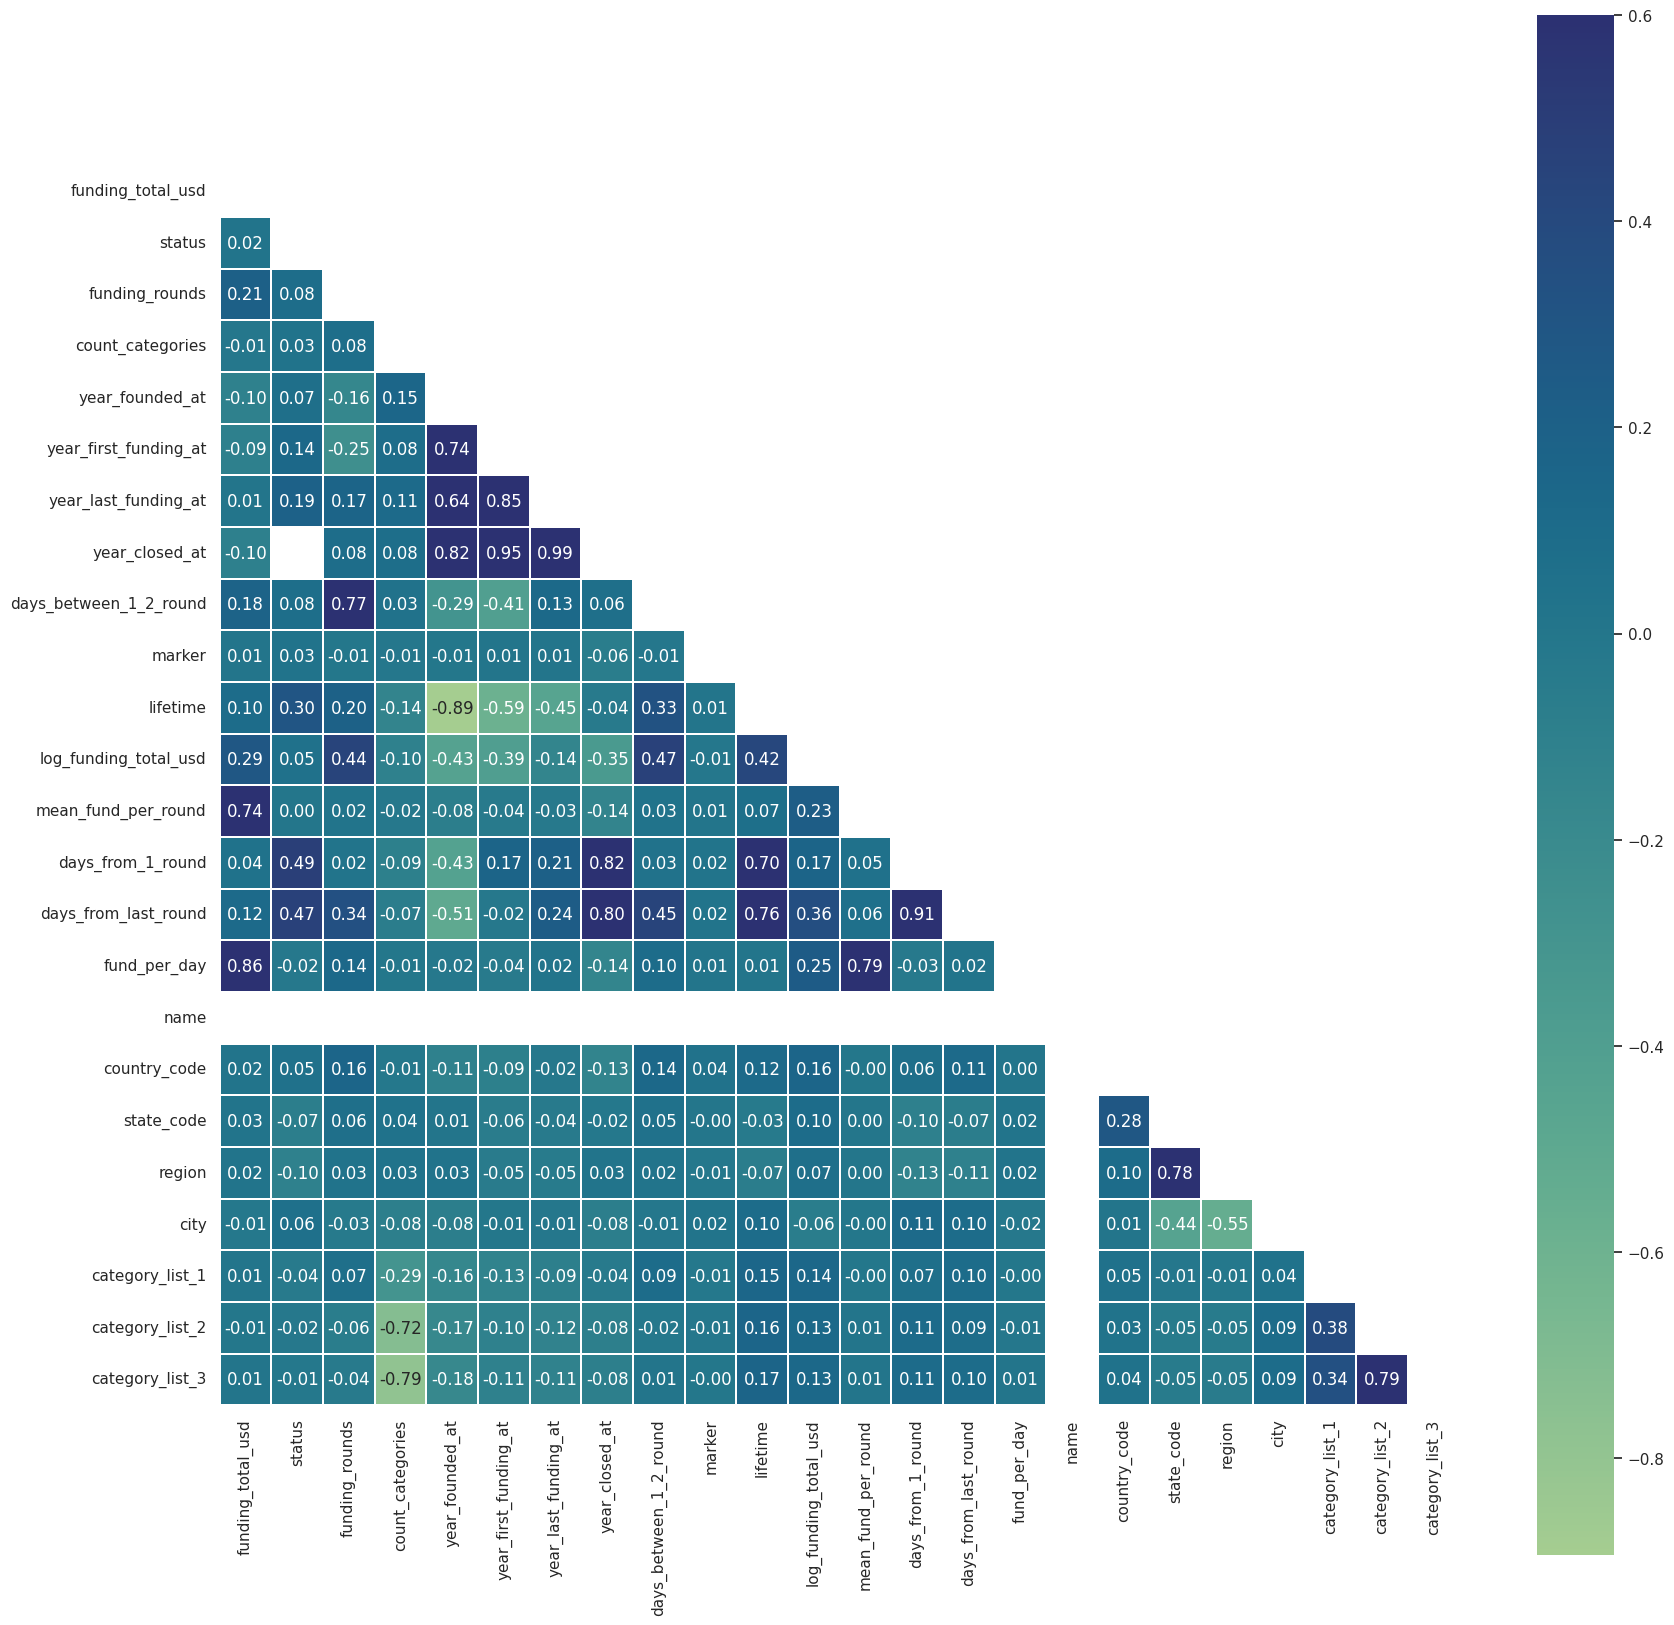

In [104]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.set_theme(style="white")
plt.figure(figsize=(20, 20))
cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask,
            square=True,
            linewidths=.3,
            vmax=0.6,

            annot=True,
            cmap=cmap,
            fmt='.2f')

plt.show()

Для снижение корреляции некоторых признаков, создадим новые путем синтеза

In [105]:
startups_train['days_per_round'] = startups_train['days_between_1_2_round'] / startups_train['funding_rounds']

In [106]:
startups_test['days_per_round'] = startups_test['days_between_1_2_round'] / startups_test['funding_rounds']

In [107]:
encoder = CountEncoder()

categorical_cols = startups_train.drop(columns='status').select_dtypes(include=['object']).columns

encoded_df = encoder.fit_transform(startups_train[categorical_cols])

l_encoder = LabelEncoder()

startups_train['status'] = l_encoder.fit_transform(startups_train['status'])

numeric_df = startups_train.select_dtypes(include=['number'])
final_df = pd.concat([numeric_df, encoded_df], axis=1)

correlation_matrix = final_df.corr()

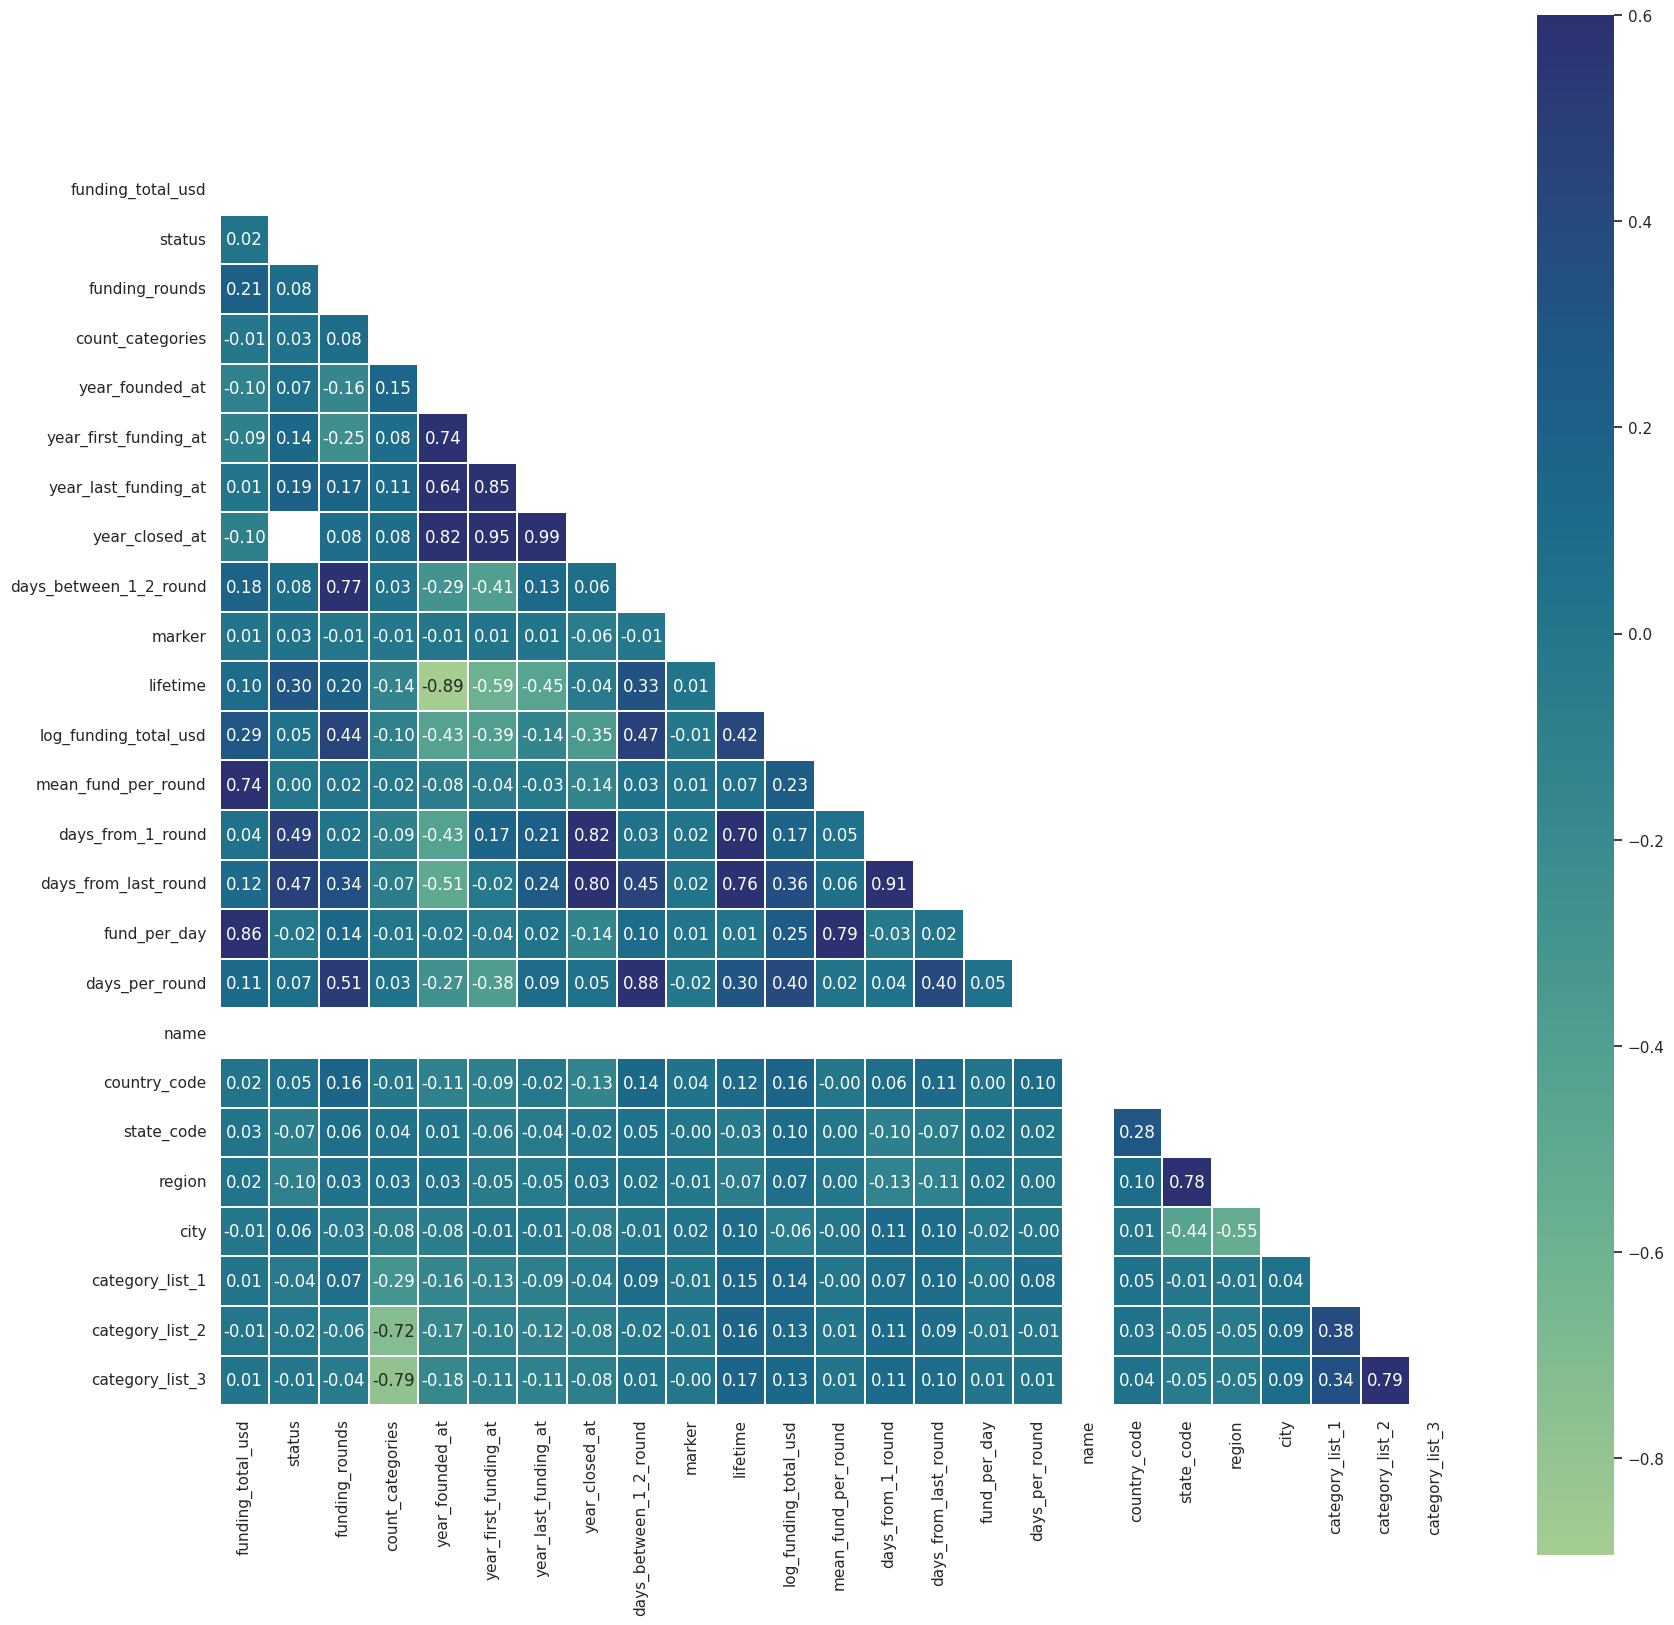

In [108]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.set_theme(style="white")
plt.figure(figsize=(20, 20))
cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask,
            square=True,
            linewidths=.3,
            vmax=0.6,

            annot=True,
            cmap=cmap,
            fmt='.2f')

plt.show()

Удалим лишние признаки

In [109]:
cols_to_drop = ['first_funding_at', 'last_funding_at', 'founded_at', 'closed_at', 'year_founded_at', 'year_closed_at']
for cd in cols_to_drop:
  startups_train.drop(columns=cd, inplace=True)

In [110]:
cols_to_drop_test = ['first_funding_at', 'last_funding_at']
for cd in cols_to_drop_test:
  startups_test.drop(columns=cd, inplace=True)

In [111]:
encoder = CountEncoder()

categorical_cols = startups_train.drop(columns='status').select_dtypes(include=['object']).columns

encoded_df = encoder.fit_transform(startups_train[categorical_cols])

l_encoder = LabelEncoder()

startups_train['status'] = l_encoder.fit_transform(startups_train['status'])

numeric_df = startups_train.select_dtypes(include=['number'])
final_df = pd.concat([numeric_df, encoded_df], axis=1)

correlation_matrix = final_df.corr()

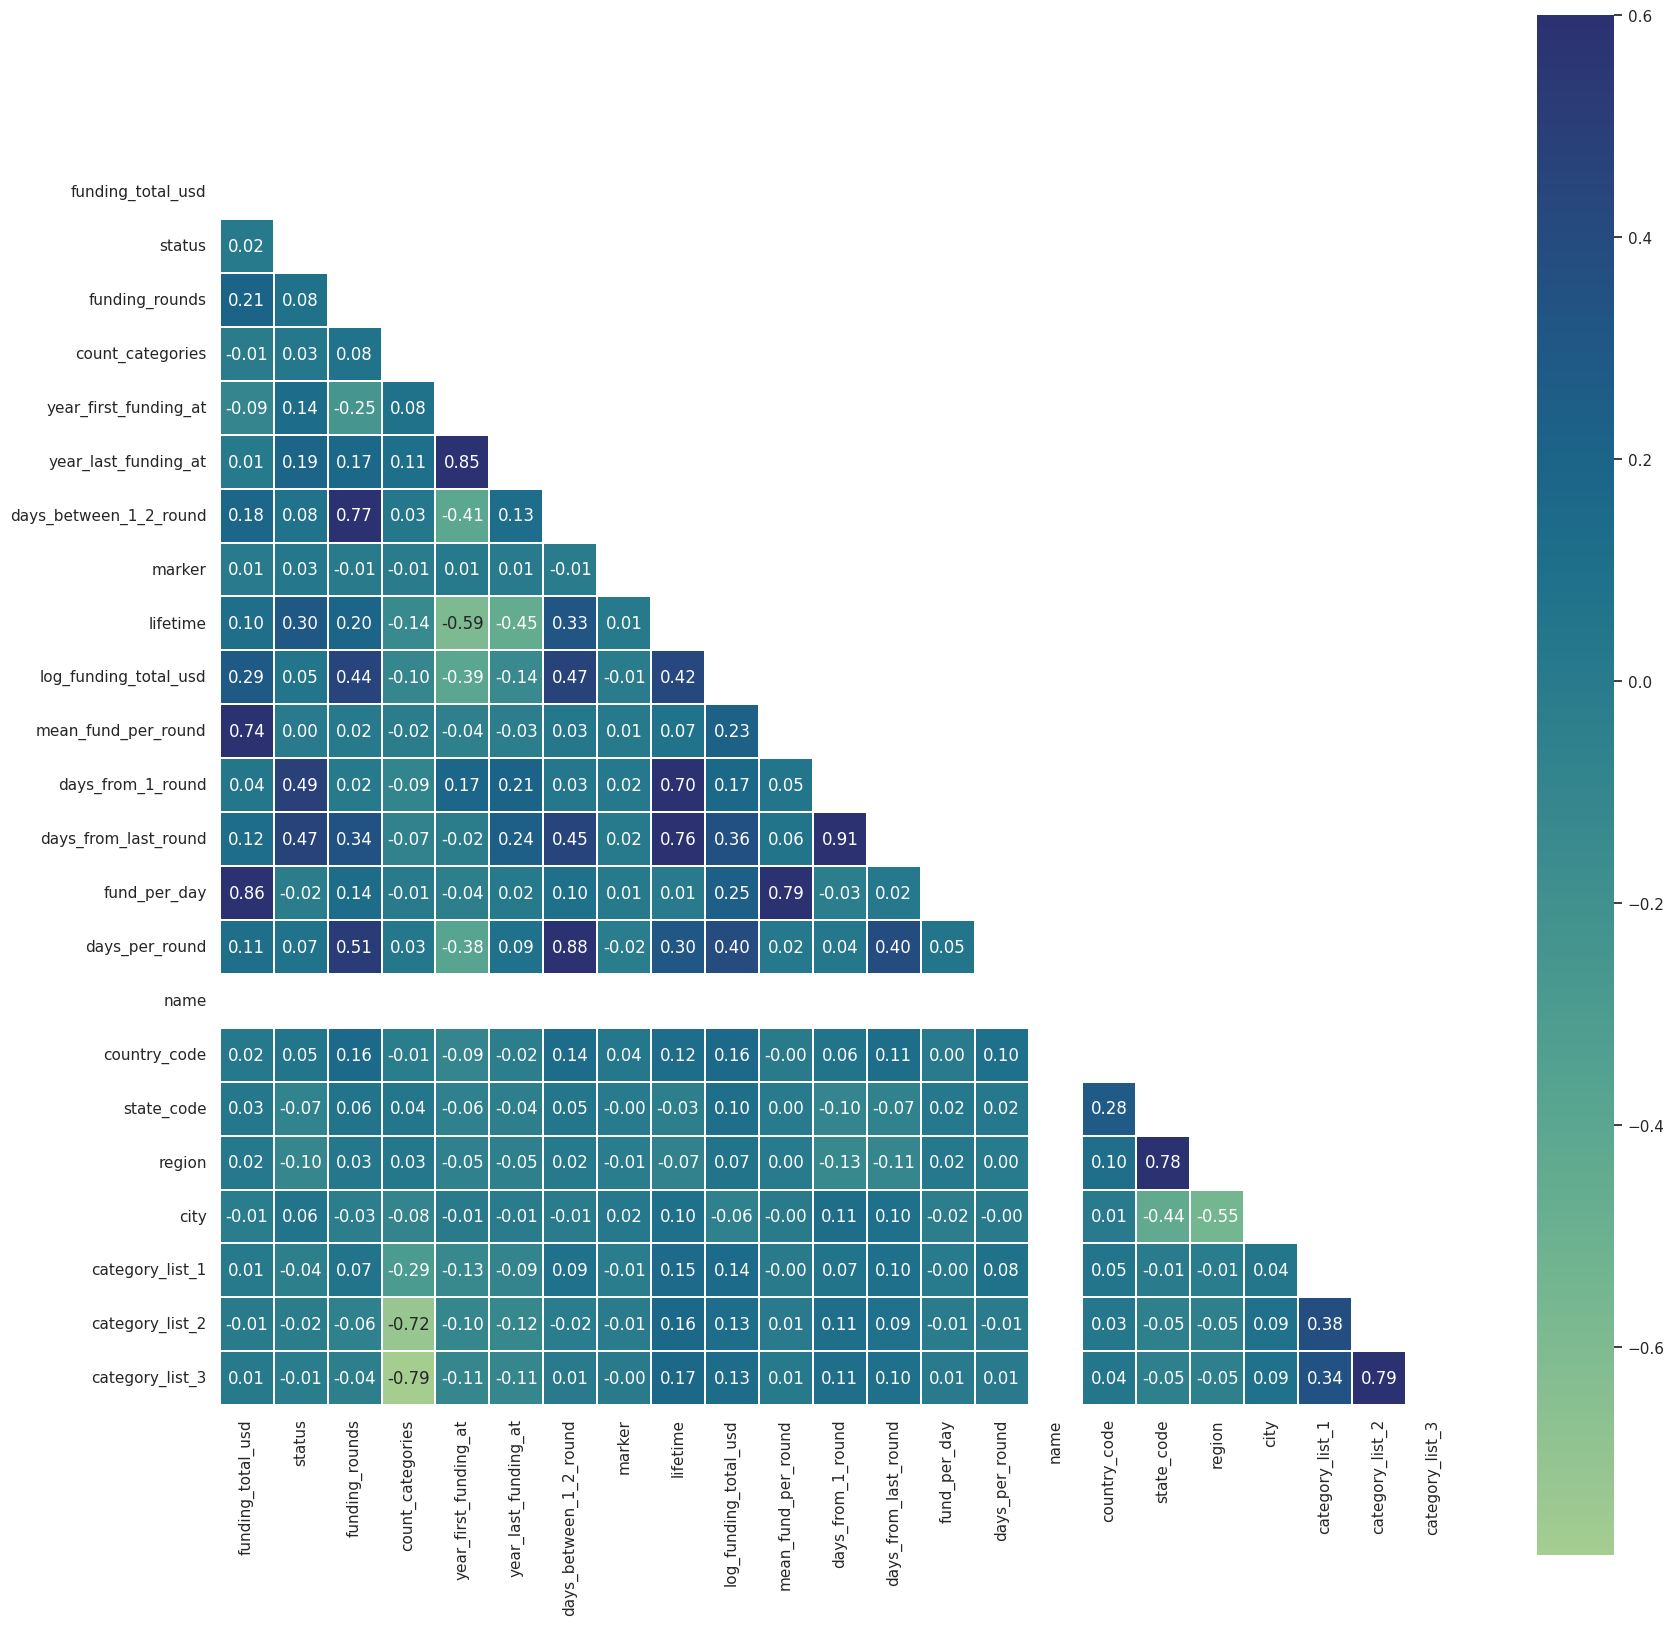

In [112]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.set_theme(style="white")
plt.figure(figsize=(20, 20))
cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask,
            square=True,
            linewidths=.3,
            vmax=0.6,

            annot=True,
            cmap=cmap,
            fmt='.2f')

plt.show()

Наблюдается мультиколлинеарность между признаками.
Удалим следующие признаки
- `year_last_funding`
- `region`
- `category_list_3`
- `name`
- `funding_total_usd`

## Пайплайн

In [113]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51555 entries, 0 to 51554
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    51555 non-null  object 
 1   funding_total_usd       41699 non-null  float64
 2   status                  51555 non-null  int64  
 3   country_code            46100 non-null  object 
 4   state_code              44853 non-null  object 
 5   region                  45257 non-null  object 
 6   city                    45257 non-null  object 
 7   funding_rounds          51555 non-null  int64  
 8   count_categories        51555 non-null  int64  
 9   category_list_1         51555 non-null  object 
 10  category_list_2         26197 non-null  object 
 11  category_list_3         20070 non-null  object 
 12  year_first_funding_at   51555 non-null  int32  
 13  year_last_funding_at    51555 non-null  int32  
 14  days_between_1_2_round  51555 non-null

In [114]:
cat_ncod_columns = (startups_train.drop(columns=['name', 'region', 'category_list_3']).select_dtypes(exclude='number').columns.tolist())
knn_columns = ['log_funding_total_usd', 'mean_fund_per_round']
num_columns = (startups_train.drop(columns=['funding_total_usd', 'log_funding_total_usd', 'year_last_funding_at', 'mean_fund_per_round', 'status'])
.select_dtypes(include='number').columns.tolist())

In [115]:
cat_ncod_pipe = Pipeline(
    [
        (
            'SimpleImputer_before_encode',
            SimpleImputer(fill_value='unknown', strategy='constant', copy=False)
        ),
       (
            'encoder',
            CountEncoder(normalize=True)
       )
    ]
)

In [116]:
knn_pipe = Pipeline([
    (
        'knnimputer',
         KNNImputer(copy=False)
    ),
    (
        'knn_coder',
        StandardScaler()
    )
  ])

In [117]:
data_preprocessor = ColumnTransformer(
    [
        ('cat_code', cat_ncod_pipe, cat_ncod_columns),
        ('knn', knn_pipe, knn_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [118]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [119]:
param_grid = [
     # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(10, 20),
        'models__min_samples_split': range(5, 10),
        'models__min_samples_leaf': range(5, 10),
        'models__criterion': ['gini', 'entropy'],
        'models__class_weight': ['balanced'],
        'preprocessor__num': ['passthrough'],
        'preprocessor__knn__knn_coder': ['passthrough'],
        'preprocessor__knn__knnimputer__n_neighbors': [2, 5],
        'preprocessor__knn__knnimputer__weights': ['uniform', 'distance']
    },
    # словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=0)],
        'models__min_samples_split': range(5, 10),
        'models__min_samples_leaf': range(5, 10),
        'models__criterion': ['gini', 'entropy'],
        'models__class_weight': ['balanced'],
        'preprocessor__num': ['passthrough'],
        'preprocessor__knn__knn_coder': ['passthrough'],
        'preprocessor__knn__knnimputer__n_neighbors': [2, 5],
        'preprocessor__knn__knnimputer__weights': ['uniform', 'distance']
    },
     {
         'models': [RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=0)],
     }
]

In [120]:
scoring = {'f1_score': 'f1',
           'roc_auc_score': 'roc_auc'
          }

rndcv = RandomizedSearchCV(
    estimator=pipe_final,
    param_distributions=param_grid,
    scoring=scoring,
    n_jobs=-1,
    cv=5,
    refit = 'f1_score',
    random_state=RANDOM_STATE
)

In [121]:
use_columns = cat_ncod_columns+knn_columns+num_columns
use_columns

['country_code',
 'state_code',
 'city',
 'category_list_1',
 'category_list_2',
 'log_funding_total_usd',
 'mean_fund_per_round',
 'funding_rounds',
 'count_categories',
 'year_first_funding_at',
 'days_between_1_2_round',
 'marker',
 'lifetime',
 'days_from_1_round',
 'days_from_last_round',
 'fund_per_day',
 'days_per_round']

In [122]:
X = startups_train[use_columns]
y = startups_train['status']
X_test=startups_test[use_columns]

X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify=y
)

In [123]:
label_encoder = LabelEncoder()

y_train_labeled = label_encoder.fit_transform(y_train)
y_valid_labeled = label_encoder.transform(y_valid)

In [124]:
rndcv.fit(X_train, y_train_labeled)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat_code',
                                                                               Pipeline(steps=[('SimpleImputer_before_encode',
                                                                                                SimpleImputer(copy=False,
                                                                                                              fill_value='unknown',
                                                                                                              strategy='constant')),
                                                                                               ('encoder',
                                                                                                CountEncoder(combine_min_nan_groups=True,
                                                                                                             normalize=True))]),
                                                                               ['country_code',
                                                                                'state_code',
                                                                                '...
                                         'models__min_samples_split': range(5, 10),
                                         'preprocessor__knn__knn_coder': ['passthrough'],
                                         'preprocessor__knn__knnimputer__n_neighbors': [2,
                                                                                        5],
                                         'preprocessor__knn__knnimputer__weights': ['uniform',
                                                                                    'distance'],
                                         'preprocessor__num': ['passthrough']},
                                        {'models': [RandomForestClassifier(n_jobs=-1,
                                                                           random_state=15)]}],
                   random_state=15, refit='f1_score',
                   scoring={'f1_score': 'f1', 'roc_auc_score': 'roc_auc'})

In [125]:
pd.DataFrame(rndcv.cv_results_).sort_values(by='rank_test_f1_score').head(10)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
1      30.960842      2.441416         9.125159        1.314755   
5      28.651163      0.878348         9.244895        0.566846   
8      19.204325      0.467759         7.932397        0.856839   
4      19.207755      0.477891         9.045913        0.428518   
0      22.181314      1.517609         8.492766        1.733006   
9      18.563977      2.018531         7.655085        1.458831   
2      20.080245      1.660742         8.863317        0.239568   
7      19.618125      0.336034         8.551147        0.672741   
6      19.874974      0.329628         8.425643        0.232272   
3      19.037726      0.531913         8.836007        0.888555   

  param_preprocessor__num param_preprocessor__knn__knnimputer__weights  \
1             passthrough                                     distance   
5             passthrough                                     distance   
8             passthrough                                     distance   
4             passthrough                                     distance   
0             passthrough                                     distance   
9             passthrough                                      uniform   
2             passthrough                                      uniform   
7             passthrough                                     distance   
6             passthrough                                     distance   
3             passthrough                                     distance   

   param_preprocessor__knn__knnimputer__n_neighbors  \
1                                                 2   
5                                                 2   
8                                                 5   
4                                                 2   
0                                                 5   
9                                                 2   
2                                                 5   
7                                                 5   
6                                                 2   
3                                                 5   

  param_preprocessor__knn__knn_coder  param_models__min_samples_split  \
1                        passthrough                                8   
5                        passthrough                                6   
8                        passthrough                                6   
4                        passthrough                                5   
0                        passthrough                                9   
9                        passthrough                                9   
2                        passthrough                                7   
7                        passthrough                                6   
6                        passthrough                                7   
3                        passthrough                                5   

   param_models__min_samples_leaf  param_models__max_depth  \
1                               6                      NaN   
5                               8                      NaN   
8                               7                     10.0   
4                               6                     12.0   
0                               6                     17.0   
9                               5                     14.0   
2                               6                     16.0   
7                               6                     19.0   
6                               7                     17.0   
3                               7                     19.0   

  param_models__criterion param_models__class_weight  \
1                 entropy                   balanced   
5                    gini                   balanced   
8                 entropy                   balanced   
4                    gini                   balanced   
0                 entropy                   balanced   
9                    

In [126]:
best_model = rndcv.best_estimator_

In [127]:
pred_prob_y = best_model.predict_proba(X_valid)[:,1]

In [128]:
best_model = rndcv.best_estimator_
pred_y_valid = best_model.predict(X_valid)
pred_prob_y_valid = best_model.predict_proba(X_valid)[:,1]

f1 = f1_score(y_valid_labeled, pred_y_valid)
roc_auc = roc_auc_score(y_valid_labeled, pred_prob_y_valid)
pd.DataFrame(data=[f1, roc_auc], index=['f1', 'roc_auc'], columns=['score'])

score
f1       0.986529
roc_auc  0.973876

In [129]:
best_model = rndcv.best_estimator_
pred_y_test = best_model.predict(X_test)
pred_prob_y_test = best_model.predict_proba(X_test)[:,1]

In [130]:
dummy_model = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy_model.fit(X_train, y_train_labeled)

DummyClassifier(random_state=15, strategy='stratified')

In [131]:
dummy_y = dummy_model.predict(X_valid)
dummy_pred_y = dummy_model.predict_proba(X_valid)[:, 1]
f1_dummy = f1_score(y_valid_labeled, dummy_y)
roc_auc_dummy = roc_auc_score(y_valid_labeled, dummy_pred_y)
pd.DataFrame(data=[f1_dummy, roc_auc_dummy], index=['f1_dummy', 'roc_auc_dummy'], columns=['score'])

score
f1_dummy       0.902621
roc_auc_dummy  0.499582

In [132]:
pd.DataFrame(pred_prob_y_test).describe()

0
count  13125.000000
mean       0.867821
std        0.269860
min        0.000000
25%        0.922493
50%        0.967724
75%        0.987144
max        1.000000

In [133]:
status = ['closed' if prob < 0.5 else 'operating' for prob in pred_prob_y_test]

# Создаем новый DataFrame
results_df = pd.DataFrame({
    'name': startups_test['name'],  # замените на реальное имя столбца с названиями компаний
    'status': status
})

In [134]:
results_df

name     status
0                  Crystalsol  operating
1            JBI Fish & Wings  operating
2                    COINPLUS  operating
3      Imagine Communications  operating
4                       DNA13  operating
...                       ...        ...
13120                   Jymob  operating
13121               GlobaTrek  operating
13122                Inkd.com     closed
13123                  AdWill  operating
13124             RingCentral  operating

[13125 rows x 2 columns]

In [135]:
results_df.set_index('name', inplace=True)
results_df.to_csv('kaggel.csv')

## Анализ признаков

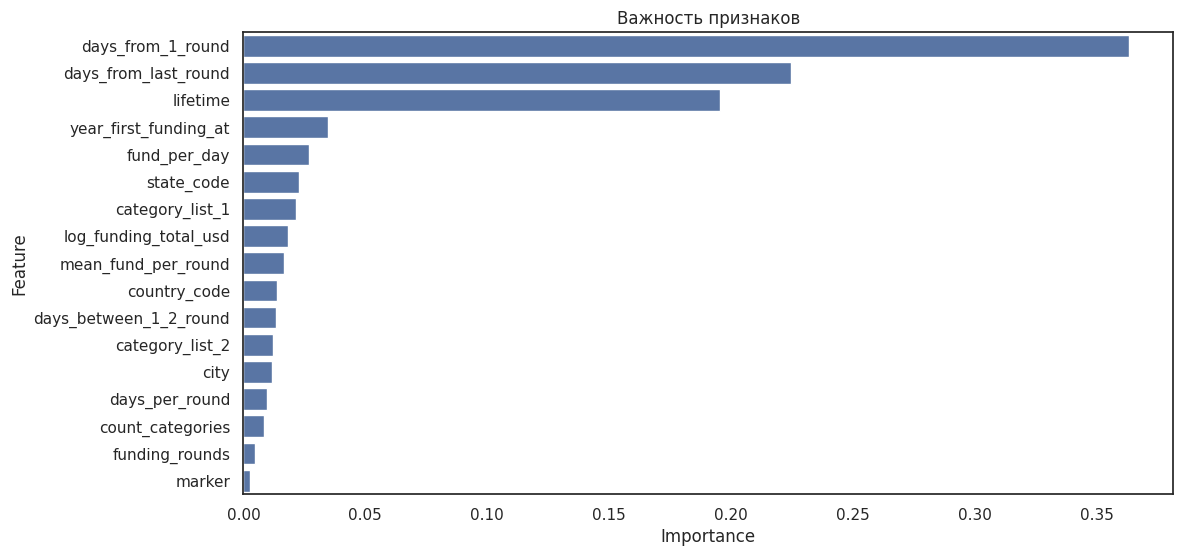

In [136]:
importances = best_model.named_steps['models'].feature_importances_

if isinstance(X_train, pd.DataFrame):
    feature_names = X_train.columns
else:
    feature_names = np.arange(X_train.shape[1])

# Создайте DataFrame для удобства
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Визуализируйте важность признаков
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.sort_values(by='Importance', ascending=False))
plt.title('Важность признаков')
plt.show()

In [137]:
X_train_transformed = best_model.named_steps['preprocessor'].fit_transform(X_train)
X_valid_transformed = best_model.named_steps['preprocessor'].transform(X_valid)

X_train_df = pd.DataFrame(
    X_train_transformed,
    columns=best_model.named_steps['preprocessor'].get_feature_names_out()
)

X_valid_df = pd.DataFrame(
    X_valid_transformed,
    columns=best_model.named_steps['preprocessor'].get_feature_names_out()
)

In [138]:
explainer = shap.SamplingExplainer(lambda x: best_model.named_steps['models'].predict_proba(x)[:,1], X_train_transformed)
shap_values = explainer.shap_values(X_valid_df.sample(n=300, random_state=RANDOM_STATE), n_jobs=-1)

  0%|          | 0/300 [00:00<?, ?it/s]

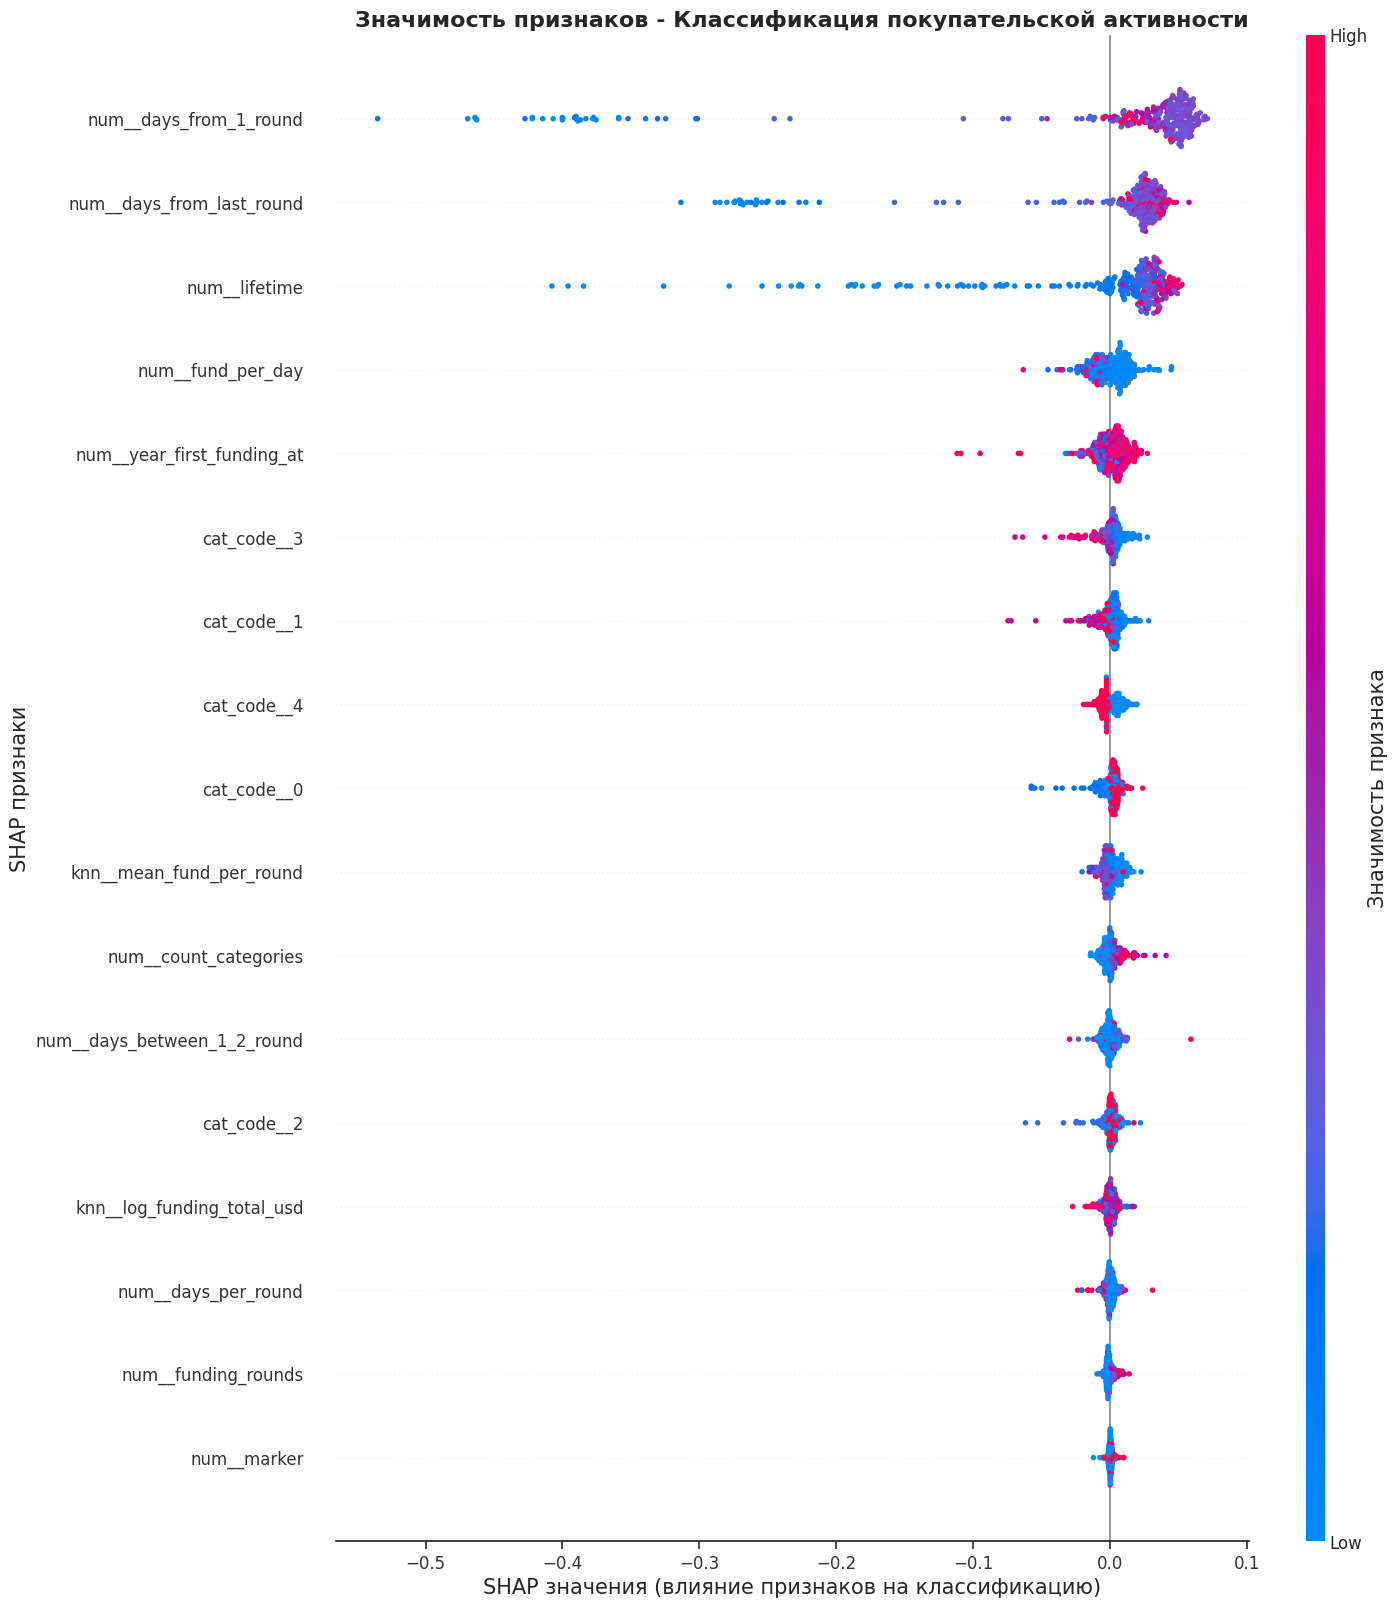

In [139]:
shap.summary_plot(shap_values, X_valid_df.sample(n=300, random_state=RANDOM_STATE), plot_size=(15, 16), show=False)
# Get the current figure and axes objects. from @GarrettCGraham code
fig, ax = plt.gcf(), plt.gca()

# Modifying main plot parameters
ax.tick_params(labelsize=12)
ax.set_xlabel("SHAP значения (влияние признаков на классификацию)", fontsize=15)
ax.set_ylabel("SHAP признаки", fontsize=15)
ax.set_title('Значимость признаков - Классификация покупательской активности', fontsize=16, weight='bold', loc='right')

# Get colorbar
cb_ax = fig.axes[1]

# Modifying color bar parameters
cb_ax.tick_params(labelsize=12)
cb_ax.set_ylabel("Значимость признака", fontsize=15)

plt.show()

## CatBoost

In [140]:
CAT_FEATURES = X_train.select_dtypes(exclude='number').columns.tolist()


for c in CAT_FEATURES:

    X_train[c].fillna('unknown', inplace=True)
    X_test[c].fillna('unknown', inplace=True)
    X_valid[c].fillna('unknown', inplace=True)

In [141]:
model = CatBoostClassifier(random_state=RANDOM_STATE, cat_features=CAT_FEATURES, verbose=0, eval_metric='F1', )

In [142]:
model.fit(X_train, y_train_labeled)

In [143]:
y_pred = model.predict(X_valid)

In [144]:
f1 = f1_score(y_valid_labeled, y_pred)
print(f'F1 Score: {f1}')

F1 Score: 0.9893390191897654


In [145]:
y_pred_test = model.predict(X_test)

In [146]:
status = ['closed' if pred == 0 else 'operating' for pred in y_pred_test]

# Создаем новый DataFrame
results_cb_df = pd.DataFrame({
    'name': startups_test['name'],  # замените на реальное имя столбца с названиями компаний
    'status': status
})

In [147]:
results_cb_df.set_index('name', inplace=True)
results_cb_df.to_csv('kaggel_CB.csv')

In [148]:
# Получаем важность признаков
feature_importances = model.get_feature_importance()

# Создаем DataFrame для удобного отображения
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Сортируем по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df

Feature  Importance
13       days_from_1_round   23.497678
12                lifetime   19.371696
14    days_from_last_round   11.861543
3          category_list_1    7.212591
0             country_code    5.357793
2                     city    4.175884
8         count_categories    3.995035
6      mean_fund_per_round    3.540833
4          category_list_2    3.529864
15            fund_per_day    3.268458
9    year_first_funding_at    2.966725
1               state_code    2.803571
10  days_between_1_2_round    2.573063
5    log_funding_total_usd    2.479493
16          days_per_round    1.816676
11                  marker    1.026324
7           funding_rounds    0.522773

In [149]:
results_cb_df.status.value_counts()

status
operating    12035
closed        1090
Name: count, dtype: int64

## Исследовательский анализ закрытых компаний

In [150]:
startups_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51555 entries, 0 to 51554
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    51555 non-null  object 
 1   funding_total_usd       41699 non-null  float64
 2   status                  51555 non-null  int64  
 3   country_code            46100 non-null  object 
 4   state_code              44853 non-null  object 
 5   region                  45257 non-null  object 
 6   city                    45257 non-null  object 
 7   funding_rounds          51555 non-null  int64  
 8   count_categories        51555 non-null  int64  
 9   category_list_1         51555 non-null  object 
 10  category_list_2         26197 non-null  object 
 11  category_list_3         20070 non-null  object 
 12  year_first_funding_at   51555 non-null  int32  
 13  year_last_funding_at    51555 non-null  int32  
 14  days_between_1_2_round  51555 non-null

In [151]:
pd.set_option('display.float_format', '{:.2f}'.format)
total_funds_per_year = startups_train.groupby('year_first_funding_at')['status'].agg('count')

closed_fund_per_year = startups_train[startups_train['status'] == 1].groupby('year_first_funding_at')['status'].agg('count')



funds_summary = pd.DataFrame({
    'total': total_funds_per_year,
    'closed': closed_fund_per_year
}).fillna(0)



funds_summary['closed_ratio'] = funds_summary['closed'] / funds_summary['total']


funds_summary = funds_summary.sort_values(by='total', ascending=False)
funds_summary

total  closed  closed_ratio
year_first_funding_at                             
2014                    9195 8839.00          0.96
2013                    7746 7403.00          0.96
2015                    6362 5687.00          0.89
2012                    6019 5535.00          0.92
2011                    4917 4460.00          0.91
2010                    3866 3449.00          0.89
2009                    3094 2702.00          0.87
2007                    2315 1917.00          0.83
2008                    2297 1875.00          0.82
2006                    1568 1341.00          0.86
2005                    1267 1094.00          0.86
2004                     703  599.00          0.85
2003                     596  495.00          0.83
2001                     462  372.00          0.81
2002                     415  347.00          0.84
2000                     344  273.00          0.79
1999                     250  185.00          0.74
1998                      49   43.00          0.88
1996                      24   17.00          0.71
1997                      18   13.00          0.72
1994                      11    7.00          0.64
1995                       9    8.00          0.89
1993                       5    1.00          0.20
1990                       5    2.00          0.40
1992                       4    1.00          0.25
1987                       3    0.00          0.00
1985                       3    0.00          0.00
1982                       2    0.00          0.00
1988                       2    0.00          0.00
1986                       1    1.00          1.00
1984                       1    0.00          0.00
1983                       1    0.00          0.00
1991                       1    0.00          0.00

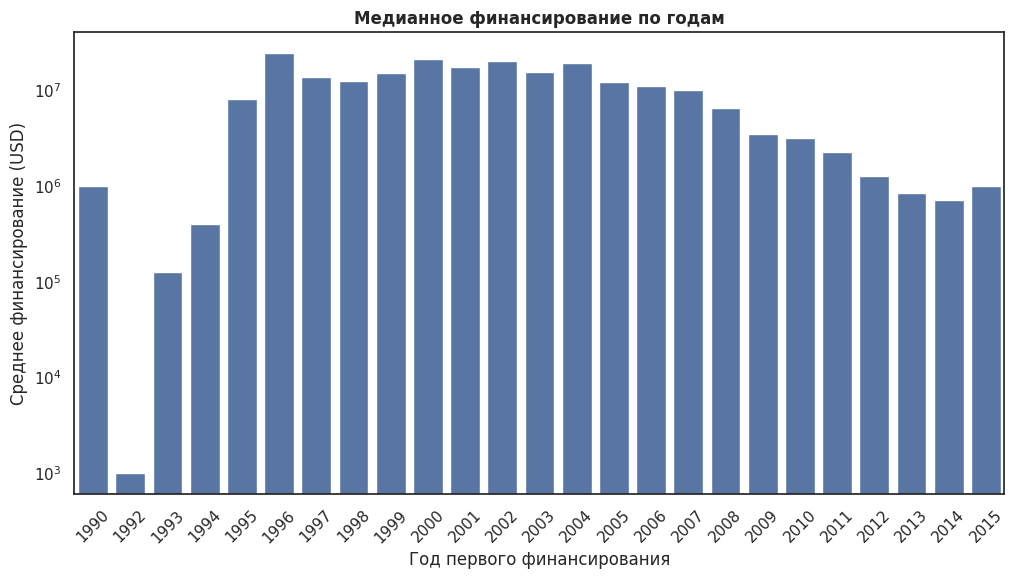

In [152]:
closed_funding_per_year = startups_train[startups_train['status'] == 1].groupby('year_first_funding_at')['funding_total_usd'].agg('median').reset_index()
sns.barplot(x='year_first_funding_at', y='funding_total_usd', data=closed_funding_per_year[closed_funding_per_year['funding_total_usd'] > 0])
plt.title('Медианное финансирование по годам', weight='bold')
plt.xlabel('Год первого финансирования')
plt.ylabel('Среднее финансирование (USD)')
plt.yscale('log')
plt.xticks(rotation=45)

plt.show()

In [153]:
closed_category = startups_train[startups_train['status'] == 1].groupby(['category_list_1'])['status'].agg('count')
closed_category.sort_values(ascending=False).head(20)

category_list_1
Biotechnology          3292
Software               2929
E-Commerce             1969
Advertising            1734
unknown                1683
Curated Web            1405
Analytics              1245
Mobile                 1243
Apps                   1067
Health Care            1027
Enterprise Software    1011
Clean Technology        983
Health and Wellness     890
Games                   889
Finance                 790
Hardware + Software     771
Education               756
Manufacturing           625
Consulting              502
Cloud Computing         464
Name: status, dtype: int64

In [154]:
сompany_total_per_cat = startups_train.groupby('category_list_1')['status'].agg('count')

closed_сompany_total_per_cat = startups_train[startups_train['status'] == 1].groupby('category_list_1')['status'].agg('count')

closed_category_mean_fund = startups_train[startups_train['status'] == 1].groupby('category_list_1')['funding_total_usd'].agg('median')

closed_summary = pd.DataFrame({
    'total': сompany_total_per_cat,
    'closed': closed_сompany_total_per_cat,
    'fund': closed_category_mean_fund
}).fillna(0)



closed_summary['closed_ratio'] = closed_summary['closed'] / closed_summary['total']


closed_summary = closed_summary.sort_values(by='closed', ascending=False)
closed_summary.head(20)

total  closed       fund  closed_ratio
category_list_1                                            
Biotechnology         3495 3292.00 7000000.00          0.94
Software              3207 2929.00 2500000.00          0.91
E-Commerce            2148 1969.00 1375748.00          0.92
Advertising           1915 1734.00 2300000.00          0.91
unknown               2407 1683.00 3000000.00          0.70
Curated Web           1737 1405.00 1000000.00          0.81
Analytics             1304 1245.00 2373181.00          0.95
Mobile                1376 1243.00 2500000.00          0.90
Apps                  1182 1067.00  622525.00          0.90
Health Care           1112 1027.00 4705480.00          0.92
Enterprise Software   1087 1011.00 5507652.00          0.93
Clean Technology      1082  983.00 7200000.00          0.91
Health and Wellness    922  890.00 2000000.00          0.97
Games                 1006  889.00 1660000.00          0.88
Finance                862  790.00 3353144.50          0.92
Hardware + Software    836  771.00 3326424.00          0.92
Education              794  756.00  610273.50          0.95
Manufacturing          660  625.00 3875000.00          0.95
Consulting             536  502.00 1000000.00          0.94
Cloud Computing        494  464.00 2706565.00          0.94

In [155]:
def cat_analysis(cat_2):
  return  startups_train[
      (startups_train['category_list_1'] == cat_2) &
      (startups_train['status'] != 0)
  ].groupby('category_list_2')['name'].agg('count').sort_values(ascending=False).head(20)

In [156]:
cat_analysis('Biotechnology')

category_list_2
Health Diagnostics                    181
Health Care                           147
Medical                                73
Health and Wellness                    39
Pharmaceuticals                        27
Clinical Trials                        16
Diagnostics                            14
Life Sciences                          11
Medical Devices                        10
Chemicals                               7
Clean Technology                        7
Diabetes                                7
Manufacturing                           6
Genetic Testing                         6
Healthcare Services                     5
Technology                              4
Hardware                                4
Health Care Information Technology      3
Health Services Industry                3
Environmental Innovation                3
Name: name, dtype: int64

In [157]:
cat_analysis('Software')

category_list_2
Technology                 15
Video                      12
Startups                    8
Web Development             7
Virtualization              6
Sports                      4
Telecommunications          4
Storage                     4
Surveys                     3
Supply Chain Management     2
Web Design                  2
Transportation              2
Training                    2
Television                  2
Tracking                    2
Web Hosting                 2
Stock Exchanges             1
Speech Recognition          1
Testing                     1
Telephony                   1
Name: name, dtype: int64

In [158]:
cat_analysis('E-Commerce')

category_list_2
Fashion                 197
Marketplaces             45
Internet                 39
Online Shopping          39
Mobile                   32
Finance                  23
Retail                   22
Furniture                20
Mobile Commerce          18
Social Commerce          16
Hospitality              16
E-Commerce Platforms     16
Enterprise Software      16
Education                15
Payments                 13
SaaS                     12
Gift Card                11
Health and Wellness      11
Lifestyle                11
Mobile Payments          10
Name: name, dtype: int64

In [159]:
cat_analysis('Advertising')

category_list_2
Analytics                111
Mobile                    61
Digital Media             47
E-Commerce                45
Brand Marketing           44
Advertising Platforms     43
Internet                  41
App Marketing             39
Internet Marketing        36
Apps                      35
Media                     28
Big Data                  25
Android                   23
Curated Web               23
Content                   22
Games                     19
Auctions                  17
Social Media              15
Coupons                   15
B2B                       14
Name: name, dtype: int64

In [160]:
cat_analysis('Mobile')

category_list_2
Software                 37
Mobile Payments          27
Wireless                 20
Networking               20
SaaS                     18
Social Media             14
Mobile Commerce          14
Telecommunications       13
Mobile Software Tools    10
Payments                  9
Photography               9
Security                  8
Photo Sharing             8
Mobile Devices            8
Music                     8
Technology                7
Semiconductors            6
Mobile Advertising        6
Sports                    6
Social Network Media      6
Name: name, dtype: int64

In [161]:
сompany_total_per_country = startups_train.groupby('country_code')['status'].agg('count')

closed_сompany_total_per_country = startups_train[startups_train['status'] == 0].groupby('country_code')['status'].agg('count')

closed_category_mean_fund_per_c = startups_train[startups_train['status'] == 0].groupby('country_code')['funding_total_usd'].agg('median')

closed_summary = pd.DataFrame({
    'total': сompany_total_per_country,
    'closed': closed_сompany_total_per_country,
    'median_fund': closed_category_mean_fund_per_c
}).fillna(0)



closed_summary['closed_ratio'] = closed_summary['closed'] / closed_summary['total']


closed_summary = closed_summary.sort_values(by='closed_ratio', ascending=False)
closed_summary.head(20)

total  closed  median_fund  closed_ratio
country_code                                          
RUS             367     130    500000.00          0.35
BRA             348      40    338834.00          0.11
SWE             369      42    688396.00          0.11
ISR             760      64   1500000.00          0.08
CAN            1501     126   3000000.00          0.08
NLD             375      31    500000.00          0.08
AUS             377      31   1980218.93          0.08
GBR            2865     233    865161.50          0.08
FRA             897      71   2600000.00          0.08
USA           29023    2266   2346250.00          0.08
ESP             604      45   1142087.50          0.07
DEU             828      61    927000.00          0.07
Other          3672     263    252520.00          0.07
ITA             318      22    812067.50          0.07
IRL             347      24    556087.00          0.07
SGP             354      20    355000.00          0.06
JPN             312      17   1215845.00          0.05
KOR             299      14   1400000.00          0.05
CHN            1232      54   9700000.00          0.04
IND            1252      53    530000.00          0.04

count   46666.00
mean     3150.60
std      1738.36
min       731.00
25%      1826.00
50%      2557.00
75%      4018.00
max      9584.00
Name: lifetime, dtype: float64

Верхний ус: 7306.0 
Нижний ус: -1462.0     
Медианное значение: 2557.0


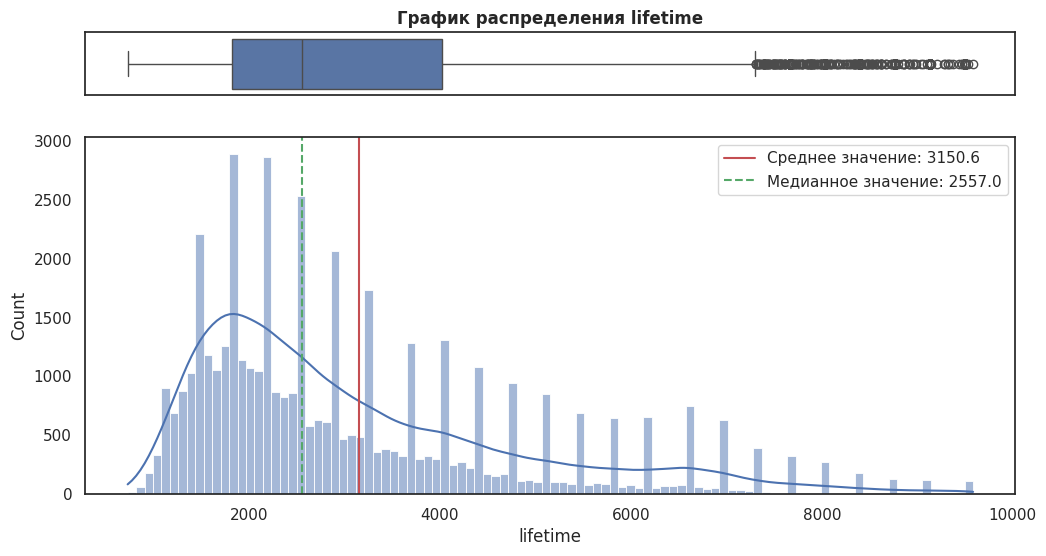

In [162]:
numeric_analysis(startups_train[startups_train['status'] == 1], 'lifetime', 'lifetime')

In [163]:
closed_companies = startups_train[startups_train['status'] == 1]
active_companies = startups_train[startups_train['status'] == 0]

mean_closed = closed_companies['lifetime'].mean()
median_closed = closed_companies['lifetime'].median()

mean_active = active_companies['lifetime'].mean()
median_active = active_companies['lifetime'].median()

In [164]:
def t_test(col):
    t_statistic, p_value = stats.ttest_ind(closed_companies[col], active_companies[col], equal_var=False)
    print(f'stat:{round(t_statistic, 3)}, p:{round(p_value, 6)}')
    if p_value > 0.05:
        print('Не существует статистически значимой разницы в продолжительности существования компании')
    else:
        print('Существует статистически значимая разница в продолжительности существования компании')


t_test('lifetime')

stat:99.952, p:0.0
Существует статистически значимая разница в продолжительности существования компании


In [165]:
print(f"Средний срок жизни активных компаний: {mean_active:.2f} дней")
print(f"Медианный срок жизни активных компаний: {median_active:.2f} дней")
print(f"Средний срок жизни закрытых компаний: {mean_closed:.2f} дней")
print(f"Медианный срок жизни закрытых компаний: {median_closed:.2f} дней")
print()
# Минимальный порог для выживания
min_lifetime_threshold = active_companies['lifetime'].min()
print(f"Минимальный срок жизни для активных компаний: {min_lifetime_threshold} дней")

Средний срок жизни активных компаний: 1342.84 дней
Медианный срок жизни активных компаний: 1008.00 дней
Средний срок жизни закрытых компаний: 3150.60 дней
Медианный срок жизни закрытых компаний: 2557.00 дней

Минимальный срок жизни для активных компаний: 19.0 дней


## Финальный отчет

**Цель настоящего исследования.**
1. Разработать модель, которая будет предсказывать продолжение деятельности компании.
2. Дать рекомендации путем определения значимых признаков.

**Набор данных:**
- `kaggle_startups_train_28062024.csv` - тренировочные данные.
- `kaggle_startups_test_28062024.csv` - тестовые данные.

**Признаки в тренировочных данных:**

- `name` - назавние компании
- `category_list` - список направлений деятельности стартапа
- `funding_total_usd` - объем инвестиций
- `status` - статус деятельности компании. Целевой признак
- `country_code` - код страны
- `state_code` - код штата
- `region` - область страны
- `city` - город расположения компании
- `funding_rounds` - кол-во раундов инвестиций
- `founded_at` - дата основании компании
- `first_funding_at` - дата первого раунда инвестиций
- `last_funding_at` - дата последнего раунда инвестиций
- `closed_at` - дата закрытия компании

**Признаки в тестовых данных:**

- `name` - назавние компании
- `category_list` - список направлений деятельности стартапа
- `funding_total_usd` - объем инвестиций
- `country_code` - код страны
- `state_code` - код штата
- `region` - область страны
- `city` - город расположения компании
- `funding_rounds` - кол-во раундов инвестиций
- `first_funding_at` - дата первого раунда инвестиций
- `last_funding_at` - дата последнего раунда инвестиций
- `lifetime` - срок существования компании. Для действующих компаний до даты среза данных 2018-01-01

**Дополнительно созданные признаки:**
- `lifetime` для тренировочных данных
- `count_categorties` - подсчет категорий компании
- `marker` - биномиальный признак, который показывает был ли рост или подение инвестиций относительно года первого раунда инвестиций
- `log_funding_total_usd` - прологарифмируемые значения объема инвестиций
- `log_lifetime` - прологарифмируемые значения продолжительности существования компании

**Используемые алгоритмы и модели:**

Для заполнения пропусков, кодирования, масштобирования и выбора модели использовался метод pipeline.

Алгоритмы заполнения пропусков:

- SimpleImputer
- KNNImputer

Алгоритмы кодирования категориальных данных:

- CountEncoder
- LabelEncoder

Алгоритмы масшатбирования:

- StandardScaler
- MinMaxScaler
- RobustScaler


Для обучения и предсказания использовался модель RandomForestClassifier и CatBoostClassifier.

Лучше всего с предсказанием справился CatBoostClassifier, следом идет  RandomForestClassifier.

**Рекомендации:**

После анализа важности признаков и исследовательского анализа новым компаниям стоит обращать внимание на следующие моменты:
1. Год запроса на финансирование. Это связано с экономическими циклами, т.к. в период роста можно получить больший объем финансирования.
2. Сферу основной деятельности.
    Топ 5 рискованных сфер, на которые стоит обратить внимани.
    - Biotechnology

    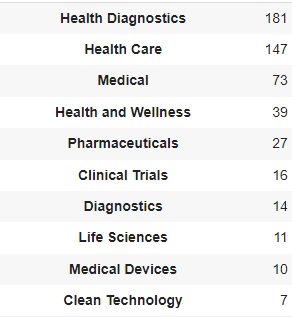

    - Software

    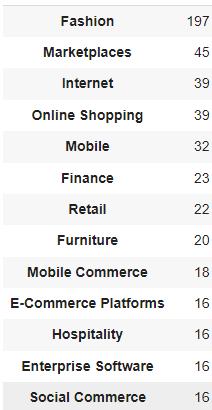

    - E-commerce

    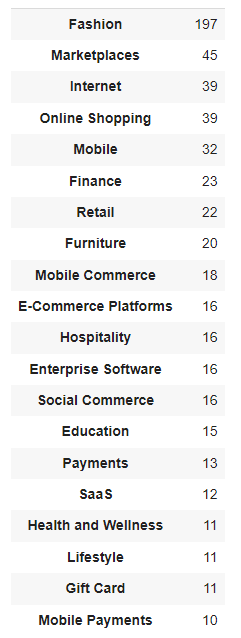

    - Advertising

    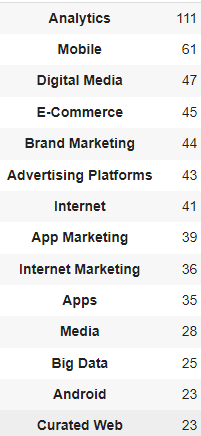

    - Mobile

    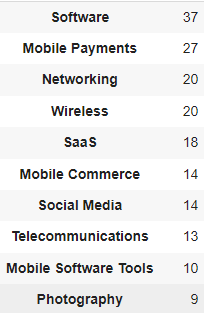

3. Компания должна просуществовать не менее 2-х лет, чтобы можно было считать, что у нее устойчивая бизнес-модель.
4. Страну размещения стартапа.

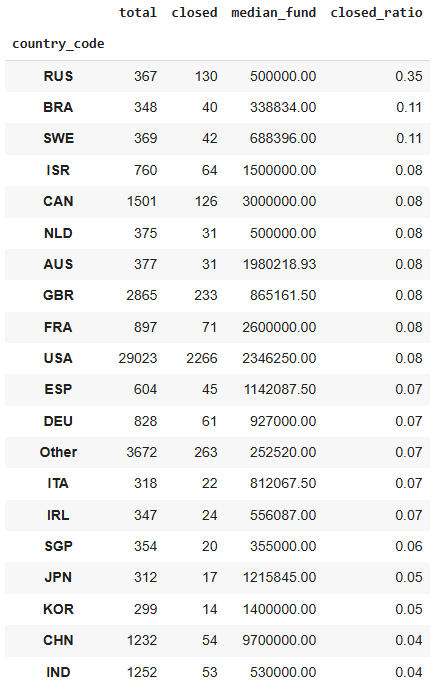


[Вернуться в начало тетрадки](#head)